# Imports

In [1]:
%matplotlib inline

from utils import (
    segment_and_renumber,
    haversine_m,
    create_seq2seq_sequences,
    plot_ship_trajectory_with_prediction
)

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
import json
from tqdm import tqdm
import random
from multi_model_comparison import compare_multiple_models, compare_multiple_models_multihorizon

In [2]:
# PyTorch GPU check
if torch.cuda.is_available():
    print(f"\nPyTorch GPU detected!")
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    DEVICE = torch.device("cuda")
else:
    print("\nNo GPU detected for PyTorch. Using CPU.")
    DEVICE = torch.device("cpu")

print(f"\nUsing device: {DEVICE}")


PyTorch GPU detected!
GPU Name: NVIDIA GeForce RTX 3050 Ti Laptop GPU

Using device: cuda


# Load Cleaned Data

In [3]:
df_clean = pd.read_csv("data/ais_data_5min_clean.csv")

# Preparing Dataset

In [4]:
SEQUENCE_LENGTH = 20
PREDICTION_HORIZON = 10
INTERVAL = 5

ORIGINAL_FEATURES = ["Latitude", "Longtitude", "SOG", "COG"]
INPUT_FEATURES = ["Latitude", "Longtitude", "delta_Lat", "delta_Lon", "SOG", "delta_COG"] 
TARGET_FEATURES = ["delta_Lat", "delta_Lon", "SOG", "delta_COG"]

MIN_SEGMENT_LENGTH = SEQUENCE_LENGTH + PREDICTION_HORIZON + 5

In [5]:
df_delta = df_clean.copy()

df_delta["COG"] = df_delta["COG"] % 360

# # Smooth COG by segment to reduce noise
df_delta['COG_smooth'] = df_delta.groupby(['MMSI', 'Segment'])['COG'].transform(
    lambda x: x.rolling(window=5, center=True, min_periods=1).mean()
)

df_delta["delta_Lat"] = df_delta.groupby(["MMSI", "Segment"])["Latitude"].diff()
df_delta["delta_Lon"] = df_delta.groupby(["MMSI", "Segment"])["Longtitude"].diff()

df_delta["delta_COG"] = df_delta.groupby(["MMSI", "Segment"])["COG_smooth"].diff()

mask_180 = df_delta['delta_COG'] > 180
mask_neg180 = df_delta['delta_COG'] < -180

df_delta.loc[mask_180, 'delta_COG'] -= 360
df_delta.loc[mask_neg180, 'delta_COG'] += 360

# Remove the first point in each segment
df_delta = df_delta.dropna(subset=["delta_Lat", "delta_Lon", "delta_COG"])

In [6]:
print(f"Data shape after computing hybrid features: {df_delta.shape}")
print(f"\nDelta statistics (movement features):")
print(f"  delta_Lat - mean: {df_delta['delta_Lat'].mean():.6f}, std: {df_delta['delta_Lat'].std():.6f}")
print(f"  delta_Lon - mean: {df_delta['delta_Lon'].mean():.6f}, std: {df_delta['delta_Lon'].std():.6f}")
print(f"  delta_Lat range: [{df_delta['delta_Lat'].min():.6f}, {df_delta['delta_Lat'].max():.6f}]")
print(f"  delta_Lon range: [{df_delta['delta_Lon'].min():.6f}, {df_delta['delta_Lon'].max():.6f}]")
print(f"\ndelta_COG statistics (circular, -180° to +180°):")
print(f"  delta_COG - mean: {df_delta['delta_COG'].mean():.4f}°, std: {df_delta['delta_COG'].std():.4f}°")
print(f"  delta_COG range: [{df_delta['delta_COG'].min():.2f}°, {df_delta['delta_COG'].max():.2f}°]")

Data shape after computing hybrid features: (66714, 12)

Delta statistics (movement features):
  delta_Lat - mean: -0.000074, std: 0.008511
  delta_Lon - mean: 0.001331, std: 0.017118
  delta_Lat range: [-0.026041, 0.026260]
  delta_Lon range: [-0.049885, 0.050367]

delta_COG statistics (circular, -180° to +180°):
  delta_COG - mean: -0.0072°, std: 15.0054°
  delta_COG range: [-80.07°, 74.32°]


### Preparing sequences

In [7]:
# Create Seq2Seq sequences: input (20 steps) → output (10 steps)
X, y, segment_info = create_seq2seq_sequences(
    df_delta,
    SEQUENCE_LENGTH,
    PREDICTION_HORIZON,
    INPUT_FEATURES,
    TARGET_FEATURES,
    MIN_SEGMENT_LENGTH
)

print(f"\nInput shape: {X.shape}")
print(f"  - {X.shape[0]} sequences")
print(f"  - {X.shape[1]} input timesteps")
print(f"  - {X.shape[2]} features: {INPUT_FEATURES}")
print(f"\nTarget shape: {y.shape}")
print(f"  - {y.shape[0]} sequences")
print(f"  - {y.shape[1]} output timesteps (prediction horizon)")
print(f"  - {y.shape[2]} features: {TARGET_FEATURES}")
print(f"\nSegments used: {len(set((s['mmsi'], s['segment']) for s in segment_info))}")


Input shape: (55437, 20, 6)
  - 55437 sequences
  - 20 input timesteps
  - 6 features: ['Latitude', 'Longtitude', 'delta_Lat', 'delta_Lon', 'SOG', 'delta_COG']

Target shape: (55437, 10, 4)
  - 55437 sequences
  - 10 output timesteps (prediction horizon)
  - 4 features: ['delta_Lat', 'delta_Lon', 'SOG', 'delta_COG']

Segments used: 383


### Storing original last positions

In [8]:
original_positions = []

for (mmsi, seg), g in df_delta.groupby(['MMSI', 'Segment']):
    if len(g) < MIN_SEGMENT_LENGTH:
        continue
    
    lats = g['Latitude'].values
    lons = g['Longtitude'].values
    cogs = g['COG'].values
    
    for i in range(len(g) - SEQUENCE_LENGTH - PREDICTION_HORIZON + 1):
        pos_record = {
            'last_lat': lats[i + SEQUENCE_LENGTH - 1],
            'last_lon': lons[i + SEQUENCE_LENGTH - 1],
            'last_cog': cogs[i + SEQUENCE_LENGTH - 1],
        }
        # Store target positions for all horizon steps
        for t in range(PREDICTION_HORIZON):
            pos_record[f'target_lat_{t}'] = lats[i + SEQUENCE_LENGTH + t]
            pos_record[f'target_lon_{t}'] = lons[i + SEQUENCE_LENGTH + t]
        
        original_positions.append(pos_record)

original_positions = pd.DataFrame(original_positions)
print(f"Stored {len(original_positions)} position records")

Stored 55437 position records


### Train test split

In [9]:
unique_mmsis = list(set([seg['mmsi'] for seg in segment_info]))
n_ships = len(unique_mmsis)

print(f"Total unique ships: {n_ships}")

mmsi_temp, mmsi_test = train_test_split(
    unique_mmsis, test_size=0.2, random_state=42, shuffle=True
)
mmsi_train, mmsi_val = train_test_split(
    mmsi_temp, test_size=0.2, random_state=42, shuffle=True
)

print(f"\nShips in training set: {len(mmsi_train)} ({len(mmsi_train)/n_ships*100:.1f}%)")
print(f"Ships in validation set: {len(mmsi_val)} ({len(mmsi_val)/n_ships*100:.1f}%)")
print(f"Ships in test set: {len(mmsi_test)} ({len(mmsi_test)/n_ships*100:.1f}%)")

mmsi_train_set = set(mmsi_train)
mmsi_val_set = set(mmsi_val)
mmsi_test_set = set(mmsi_test)

train_indices = [i for i, seg in enumerate(segment_info) if seg['mmsi'] in mmsi_train_set]
val_indices = [i for i, seg in enumerate(segment_info) if seg['mmsi'] in mmsi_val_set]
test_indices = [i for i, seg in enumerate(segment_info) if seg['mmsi'] in mmsi_test_set]

X_train_raw = X[train_indices]
y_train_raw = y[train_indices]

X_val_raw = X[val_indices]
y_val_raw = y[val_indices]

X_test_raw = X[test_indices]
y_test_raw = y[test_indices]

original_positions_test = original_positions.iloc[test_indices].reset_index(drop=True)

print(f"\nSequences in training set: {X_train_raw.shape[0]} ({X_train_raw.shape[0]/X.shape[0]*100:.1f}%)")
print(f"Sequences in validation set: {X_val_raw.shape[0]} ({X_val_raw.shape[0]/X.shape[0]*100:.1f}%)")
print(f"Sequences in test set: {X_test_raw.shape[0]} ({X_test_raw.shape[0]/X.shape[0]*100:.1f}%)")
print(f"Test positions: {len(original_positions_test)} records stored for evaluation")

Total unique ships: 272

Ships in training set: 173 (63.6%)
Ships in validation set: 44 (16.2%)
Ships in test set: 55 (20.2%)

Sequences in training set: 34684 (62.6%)
Sequences in validation set: 9058 (16.3%)
Sequences in test set: 11695 (21.1%)
Test positions: 11695 records stored for evaluation


# Normalize data

In [10]:
n_samples_train, n_timesteps, n_features = X_train_raw.shape
n_target_steps = y_train_raw.shape[1]
n_target_features = y_train_raw.shape[2]

print(f"Input shape: ({n_samples_train}, {n_timesteps}, {n_features})")
print(f"Target shape: {y_train_raw.shape} (samples, horizon, features)")
print(f"Features: {INPUT_FEATURES}")

coords_indices = [0, 1]
delta_indices = [2, 3, 4, 5]

X_train_coords = X_train_raw[:, :, coords_indices]
X_val_coords = X_val_raw[:, :, coords_indices]
X_test_coords = X_test_raw[:, :, coords_indices]

X_train_deltas = X_train_raw[:, :, delta_indices]
X_val_deltas = X_val_raw[:, :, delta_indices]
X_test_deltas = X_test_raw[:, :, delta_indices]

# Normalize coordinates (Lat, Lon)
X_train_coords_reshaped = X_train_coords.reshape(-1, len(coords_indices))

scaler_lat_lon = StandardScaler()
X_train_coords_normalized = scaler_lat_lon.fit_transform(X_train_coords_reshaped)
X_train_coords_normalized = X_train_coords_normalized.reshape(n_samples_train, n_timesteps, len(coords_indices))

X_val_coords_reshaped = X_val_coords.reshape(-1, len(coords_indices))
X_val_coords_normalized = scaler_lat_lon.transform(X_val_coords_reshaped).reshape(X_val_raw.shape[0], n_timesteps, len(coords_indices))

X_test_coords_reshaped = X_test_coords.reshape(-1, len(coords_indices))
X_test_coords_normalized = scaler_lat_lon.transform(X_test_coords_reshaped).reshape(X_test_raw.shape[0], n_timesteps, len(coords_indices))

print(f"Coordinate scaler stats:")
print(f"   Means: {scaler_lat_lon.mean_}")
print(f"   Stds: {scaler_lat_lon.scale_}")

# Normalize delta features
X_train_deltas_reshaped = X_train_deltas.reshape(-1, len(delta_indices))

scaler_X = StandardScaler()
X_train_deltas_normalized = scaler_X.fit_transform(X_train_deltas_reshaped)
X_train_deltas_normalized = X_train_deltas_normalized.reshape(n_samples_train, n_timesteps, len(delta_indices))

X_val_deltas_reshaped = X_val_deltas.reshape(-1, len(delta_indices))
X_val_deltas_normalized = scaler_X.transform(X_val_deltas_reshaped).reshape(X_val_raw.shape[0], n_timesteps, len(delta_indices))

X_test_deltas_reshaped = X_test_deltas.reshape(-1, len(delta_indices))
X_test_deltas_normalized = scaler_X.transform(X_test_deltas_reshaped).reshape(X_test_raw.shape[0], n_timesteps, len(delta_indices))

print(f"Delta scaler stats:")
print(f"   Means: {scaler_X.mean_}")
print(f"   Stds: {scaler_X.scale_}")

# Concatenate normalized coordinates + normalized deltas
X_train = np.concatenate([X_train_coords_normalized, X_train_deltas_normalized], axis=2)
X_val = np.concatenate([X_val_coords_normalized, X_val_deltas_normalized], axis=2)
X_test = np.concatenate([X_test_coords_normalized, X_test_deltas_normalized], axis=2)

# Normalize 3D targets: reshape to 2D, scale, reshape back
scaler_y = StandardScaler()
y_train_reshaped = y_train_raw.reshape(-1, n_target_features)
y_train_normalized = scaler_y.fit_transform(y_train_reshaped)
y_train = y_train_normalized.reshape(y_train_raw.shape[0], n_target_steps, n_target_features)

y_val_reshaped = y_val_raw.reshape(-1, n_target_features)
y_val = scaler_y.transform(y_val_reshaped).reshape(y_val_raw.shape[0], n_target_steps, n_target_features)

y_test_reshaped = y_test_raw.reshape(-1, n_target_features)
y_test = scaler_y.transform(y_test_reshaped).reshape(y_test_raw.shape[0], n_target_steps, n_target_features)

print(f"Target scaler stats:")
print(f"   Means: {scaler_y.mean_}")
print(f"   Stds: {scaler_y.scale_}")

print(f"\nFinal normalized shapes:")
print(f"   X_train: {X_train.shape}")
print(f"   y_train: {y_train.shape}")

Input shape: (34684, 20, 6)
Target shape: (34684, 10, 4) (samples, horizon, features)
Features: ['Latitude', 'Longtitude', 'delta_Lat', 'delta_Lon', 'SOG', 'delta_COG']
Coordinate scaler stats:
   Means: [55.96591165 11.30491072]
   Stds: [1.10323788 2.00862477]
Delta scaler stats:
   Means: [-1.12896989e-04  2.31062929e-03  3.98687071e+00  2.07239892e-02]
   Stds: [8.83519939e-03 1.70775185e-02 2.75889574e+00 1.49469561e+01]
Target scaler stats:
   Means: [-1.74899687e-04  2.36345112e-03  3.94615337e+00  2.76355060e-02]
   Stds: [8.74838895e-03 1.69977744e-02 2.76175096e+00 1.49292257e+01]

Final normalized shapes:
   X_train: (34684, 20, 6)
   y_train: (34684, 10, 4)


# Note: don't run the cell with Training loop

## Convert to Pytorch

In [11]:
X_train_tensor = torch.FloatTensor(X_train).to(DEVICE)
y_train_tensor = torch.FloatTensor(y_train).to(DEVICE)
X_val_tensor = torch.FloatTensor(X_val).to(DEVICE)
y_val_tensor = torch.FloatTensor(y_val).to(DEVICE)
X_test_tensor = torch.FloatTensor(X_test).to(DEVICE)
y_test_tensor = torch.FloatTensor(y_test).to(DEVICE)

BATCH_SIZE = 64

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")
print(f"Data moved to: {DEVICE}")

Training batches: 542
Validation batches: 142
Test batches: 183
Data moved to: cuda


## GRU Encoder-Decoder Model

In [12]:
class Seq2SeqGRU(nn.Module):
    def __init__(self, n_input_features, n_output_features, pred_horizon, 
                 encoder_hidden=128, decoder_hidden=64, n_layers=2, dropout=0.3):
        super(Seq2SeqGRU, self).__init__()
        
        self.pred_horizon = pred_horizon
        self.n_output_features = n_output_features
        self.decoder_hidden = decoder_hidden
        
        # Encoder
        self.encoder = nn.GRU(
            n_input_features, encoder_hidden, 
            num_layers=n_layers, batch_first=True, dropout=dropout
        )
        
        # Bridge
        self.bridge = nn.Linear(encoder_hidden, decoder_hidden)
        
        # Decoder
        self.decoder = nn.GRU(
            n_output_features, decoder_hidden,
            num_layers=n_layers, batch_first=True, dropout=dropout
        )
        
        # Output projection
        self.fc_out = nn.Sequential(
            nn.Linear(decoder_hidden, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, n_output_features)
        )
        
    def forward(self, x, teacher_forcing_ratio=0.0, target=None):
        batch_size = x.size(0)
        
        encoder_out, encoder_hidden = self.encoder(x)

        decoder_hidden = torch.tanh(self.bridge(encoder_hidden[-1])).unsqueeze(0)
        decoder_hidden = decoder_hidden.repeat(2, 1, 1)
        
        decoder_input = torch.zeros(batch_size, 1, self.n_output_features).to(x.device)
        
        outputs = []
        for t in range(self.pred_horizon):
            decoder_out, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
            
            output = self.fc_out(decoder_out.squeeze(1))
            outputs.append(output)
            
            if target is not None and random.random() < teacher_forcing_ratio:
                decoder_input = target[:, t:t+1, :]
            else:
                decoder_input = output.unsqueeze(1)
        
        outputs = torch.stack(outputs, dim=1)
        return outputs

model = Seq2SeqGRU(
    n_input_features=len(INPUT_FEATURES),
    n_output_features=len(TARGET_FEATURES),
    pred_horizon=PREDICTION_HORIZON,
    encoder_hidden=128,
    decoder_hidden=64,
    n_layers=2,
    dropout=0.3
).to(DEVICE)

print(model)
print(f"\nModel moved to: {DEVICE}")

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Seq2SeqGRU(
  (encoder): GRU(6, 128, num_layers=2, batch_first=True, dropout=0.3)
  (bridge): Linear(in_features=128, out_features=64, bias=True)
  (decoder): GRU(4, 64, num_layers=2, batch_first=True, dropout=0.3)
  (fc_out): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=64, out_features=4, bias=True)
  )
)

Model moved to: cuda
Total parameters: 202,372
Trainable parameters: 202,372


In [13]:
OUTPUT_DIR = "models/gru_enc_dec"
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(f"{OUTPUT_DIR}/plots", exist_ok=True)

print(f"Output directory: {OUTPUT_DIR}")

PATIENCE = 15

criterion = nn.SmoothL1Loss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-6
)

INITIAL_TF_RATIO = 0.5
TF_DECAY = 0.98

print("\nSeq2Seq Training components configured:")
print(f"  - Loss: Smooth L1 (Huber) over {PREDICTION_HORIZON} steps")
print("  - Optimizer: Adam (lr=0.001)")
print("  - Scheduler: ReduceLROnPlateau (factor=0.5, patience=5)")
print(f"  - Teacher Forcing: {INITIAL_TF_RATIO} → decays by {TF_DECAY}/epoch")
print(f"  - Early Stopping: patience={PATIENCE}")
print(f"  - Dropout: 0.3 (encoder/decoder), 0.1 (output layer)")

Output directory: models/gru_enc_dec

Seq2Seq Training components configured:
  - Loss: Smooth L1 (Huber) over 10 steps
  - Optimizer: Adam (lr=0.001)
  - Scheduler: ReduceLROnPlateau (factor=0.5, patience=5)
  - Teacher Forcing: 0.5 → decays by 0.98/epoch
  - Early Stopping: patience=15
  - Dropout: 0.3 (encoder/decoder), 0.1 (output layer)


In [ ]:
# Training loop
EPOCHS = 100

history = {
    'train_loss': [],
    'val_loss': [],
    'train_mae': [],
    'val_mae': [],
    'lr': [],
    'teacher_forcing': []
}

best_val_loss = float('inf')
patience_counter = 0
best_model_state = None
teacher_forcing_ratio = INITIAL_TF_RATIO

print(f"Training Seq2Seq GRU ({PREDICTION_HORIZON}-step prediction)")

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0
    train_mae = 0.0
    
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        
        outputs = model(batch_X, teacher_forcing_ratio=teacher_forcing_ratio, target=batch_y)
        
        loss = criterion(outputs, batch_y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        train_loss += loss.item()
        train_mae += torch.mean(torch.abs(outputs - batch_y)).item()
    
    train_loss /= len(train_loader)
    train_mae /= len(train_loader)
    
    model.eval()
    val_loss = 0.0
    val_mae = 0.0
    
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            outputs = model(batch_X, teacher_forcing_ratio=0.0)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
            val_mae += torch.mean(torch.abs(outputs - batch_y)).item()
    
    val_loss /= len(val_loader)
    val_mae /= len(val_loader)

    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    
    teacher_forcing_ratio = max(0.0, teacher_forcing_ratio * TF_DECAY)
    
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_mae'].append(train_mae)
    history['val_mae'].append(val_mae)
    history['lr'].append(current_lr)
    history['teacher_forcing'].append(teacher_forcing_ratio)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_state = model.state_dict().copy()
        
        torch.save(best_model_state, f'{OUTPUT_DIR}/best_model.pth')
        print(f"Epoch {epoch+1}/{EPOCHS} - loss: {train_loss:.4f} - mae: {train_mae:.4f} - val_loss: {val_loss:.4f} - val_mae: {val_mae:.4f} - tf: {teacher_forcing_ratio:.3f} ✓")
    else:
        patience_counter += 1
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}/{EPOCHS} - loss: {train_loss:.4f} - mae: {train_mae:.4f} - val_loss: {val_loss:.4f} - val_mae: {val_mae:.4f} - tf: {teacher_forcing_ratio:.3f}")
    
    if patience_counter >= PATIENCE:
        print(f"\nEarly stopping triggered after {epoch+1} epochs")
        break

if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"\nRestored best model with val_loss: {best_val_loss:.4f}")

# Save final model and history
torch.save(model.state_dict(), f'{OUTPUT_DIR}/best_model.pth')
with open(f'{OUTPUT_DIR}/training_history.json', 'w') as f:
    json.dump(history, f)

print(f"\nModel saved to: {OUTPUT_DIR}/best_model.pth")

Training Seq2Seq GRU (10-step prediction)
Epoch 1/100 - loss: 0.1105 - mae: 0.2686 - val_loss: 0.0951 - val_mae: 0.2274 - tf: 0.490 ✓
Epoch 2/100 - loss: 0.0877 - mae: 0.2269 - val_loss: 0.0938 - val_mae: 0.2249 - tf: 0.480 ✓
Epoch 3/100 - loss: 0.0848 - mae: 0.2212 - val_loss: 0.0915 - val_mae: 0.2301 - tf: 0.471 ✓
Epoch 4/100 - loss: 0.0832 - mae: 0.2172 - val_loss: 0.0899 - val_mae: 0.2244 - tf: 0.461 ✓
Epoch 5/100 - loss: 0.0817 - mae: 0.2119 - val_loss: 0.0878 - val_mae: 0.2165 - tf: 0.452 ✓
Epoch 7/100 - loss: 0.0804 - mae: 0.2082 - val_loss: 0.0862 - val_mae: 0.2089 - tf: 0.434 ✓
Epoch 10/100 - loss: 0.0805 - mae: 0.2078 - val_loss: 0.0878 - val_mae: 0.2182 - tf: 0.409
Epoch 11/100 - loss: 0.0809 - mae: 0.2071 - val_loss: 0.0860 - val_mae: 0.2112 - tf: 0.400 ✓
Epoch 12/100 - loss: 0.0808 - mae: 0.2071 - val_loss: 0.0844 - val_mae: 0.2020 - tf: 0.392 ✓
Epoch 13/100 - loss: 0.0801 - mae: 0.2047 - val_loss: 0.0826 - val_mae: 0.1964 - tf: 0.385 ✓
Epoch 15/100 - loss: 0.0808 - mae: 0

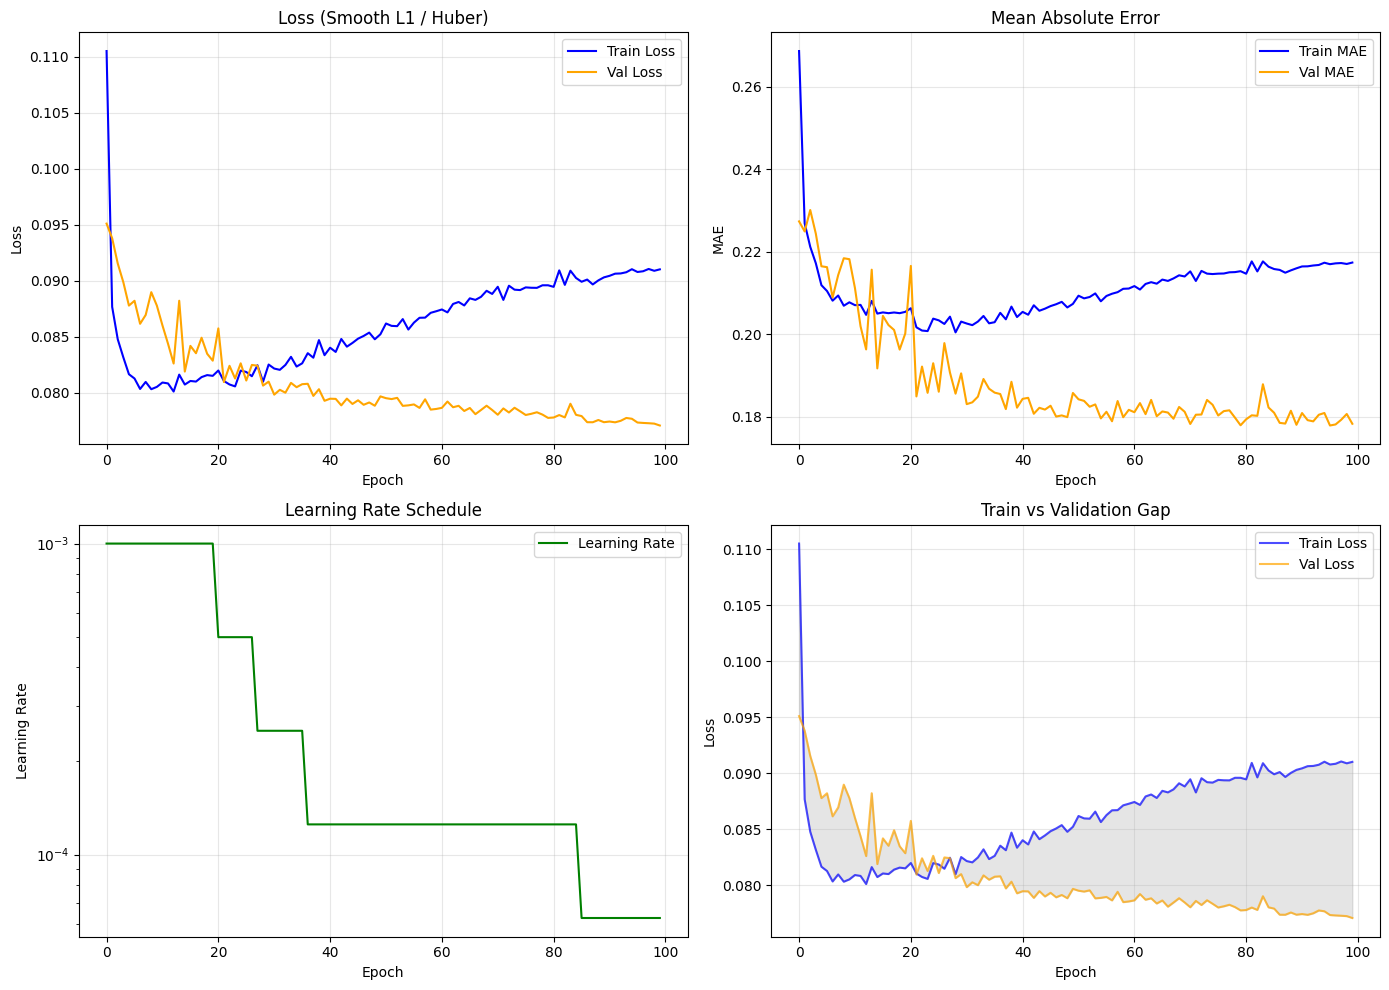


Training Summary:
  Total epochs: 100
  Best val_loss: 0.0771 (epoch 100)
  Final train_loss: 0.0910
  Final val_loss: 0.0771
  Final train_mae: 0.2174
  Final val_mae: 0.1783

Plot saved to: models/gru_enc_dec/plots/training_history.png


In [ ]:
# Training loop
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot Loss
axes[0, 0].plot(history['train_loss'], label='Train Loss', color='blue')
axes[0, 0].plot(history['val_loss'], label='Val Loss', color='orange')
axes[0, 0].set_title('Loss (Smooth L1 / Huber)')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot MAE
axes[0, 1].plot(history['train_mae'], label='Train MAE', color='blue')
axes[0, 1].plot(history['val_mae'], label='Val MAE', color='orange')
axes[0, 1].set_title('Mean Absolute Error')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('MAE')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot Learning Rate
axes[1, 0].plot(history['lr'], label='Learning Rate', color='green')
axes[1, 0].set_title('Learning Rate Schedule')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Learning Rate')
axes[1, 0].set_yscale('log')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot Train vs Val Loss comparison
axes[1, 1].plot(history['train_loss'], label='Train Loss', color='blue', alpha=0.7)
axes[1, 1].plot(history['val_loss'], label='Val Loss', color='orange', alpha=0.7)
axes[1, 1].fill_between(range(len(history['train_loss'])), 
                         history['train_loss'], history['val_loss'], 
                         alpha=0.2, color='gray')
axes[1, 1].set_title('Train vs Validation Gap')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/plots/training_history.png', dpi=150)
plt.show()

# Print summary statistics
print(f"\nTraining Summary:")
print(f"  Total epochs: {len(history['train_loss'])}")
print(f"  Best val_loss: {min(history['val_loss']):.4f} (epoch {history['val_loss'].index(min(history['val_loss']))+1})")
print(f"  Final train_loss: {history['train_loss'][-1]:.4f}")
print(f"  Final val_loss: {history['val_loss'][-1]:.4f}")
print(f"  Final train_mae: {history['train_mae'][-1]:.4f}")
print(f"  Final val_mae: {history['val_mae'][-1]:.4f}")
print(f"\nPlot saved to: {OUTPUT_DIR}/plots/training_history.png")

## LSTM Encoder-Decoder Model

In [14]:
class Seq2SeqLSTM(nn.Module):
    def __init__(self, n_input_features, n_output_features, pred_horizon, 
                 encoder_hidden=128, decoder_hidden=64, n_layers=2, dropout=0.3):
        super(Seq2SeqLSTM, self).__init__()
        
        self.pred_horizon = pred_horizon
        self.n_output_features = n_output_features
        self.decoder_hidden = decoder_hidden
        self.n_layers = n_layers
        
        # Encoder
        self.encoder = nn.LSTM(
            n_input_features, encoder_hidden, 
            num_layers=n_layers, batch_first=True, dropout=dropout
        )
        
        # Bridge for hidden state
        self.bridge_h = nn.Linear(encoder_hidden, decoder_hidden)
        # Bridge for cell state
        self.bridge_c = nn.Linear(encoder_hidden, decoder_hidden)
        
        # Decoder
        self.decoder = nn.LSTM(
            n_output_features, decoder_hidden,
            num_layers=n_layers, batch_first=True, dropout=dropout
        )
        
        # Output projection
        self.fc_out = nn.Sequential(
            nn.Linear(decoder_hidden, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, n_output_features)
        )
        
    def forward(self, x, teacher_forcing_ratio=0.0, target=None):
        batch_size = x.size(0)
        
        # LSTM returns (output, (h_n, c_n))
        encoder_out, (h_n, c_n) = self.encoder(x)

        decoder_h = torch.tanh(self.bridge_h(h_n[-1])).unsqueeze(0)
        decoder_c = torch.tanh(self.bridge_c(c_n[-1])).unsqueeze(0)
        
        decoder_h = decoder_h.repeat(self.n_layers, 1, 1)
        decoder_c = decoder_c.repeat(self.n_layers, 1, 1)
        
        decoder_hidden = (decoder_h, decoder_c)
        
        decoder_input = torch.zeros(batch_size, 1, self.n_output_features).to(x.device)
        
        outputs = []
        for t in range(self.pred_horizon):
            decoder_out, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
            
            output = self.fc_out(decoder_out.squeeze(1))
            outputs.append(output)
            
            if target is not None and random.random() < teacher_forcing_ratio:
                decoder_input = target[:, t:t+1, :]
            else:
                decoder_input = output.unsqueeze(1)
        
        outputs = torch.stack(outputs, dim=1)
        return outputs

model_lstm = Seq2SeqLSTM(
    n_input_features=len(INPUT_FEATURES),
    n_output_features=len(TARGET_FEATURES),
    pred_horizon=PREDICTION_HORIZON,
    encoder_hidden=128,
    decoder_hidden=64,
    n_layers=2,
    dropout=0.3
).to(DEVICE)

print(model_lstm)
print(f"\nModel moved to: {DEVICE}")

# Count parameters
total_params = sum(p.numel() for p in model_lstm.parameters())
trainable_params = sum(p.numel() for p in model_lstm.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Seq2SeqLSTM(
  (encoder): LSTM(6, 128, num_layers=2, batch_first=True, dropout=0.3)
  (bridge_h): Linear(in_features=128, out_features=64, bias=True)
  (bridge_c): Linear(in_features=128, out_features=64, bias=True)
  (decoder): LSTM(4, 64, num_layers=2, batch_first=True, dropout=0.3)
  (fc_out): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=64, out_features=4, bias=True)
  )
)

Model moved to: cuda
Total parameters: 273,860
Trainable parameters: 273,860


In [15]:
OUTPUT_DIR_LSTM = "models/lstm_enc_dec"
os.makedirs(OUTPUT_DIR_LSTM, exist_ok=True)
os.makedirs(f"{OUTPUT_DIR_LSTM}/plots", exist_ok=True)

print(f"Output directory: {OUTPUT_DIR_LSTM}")

PATIENCE = 15

criterion = nn.SmoothL1Loss()

optimizer = torch.optim.Adam(model_lstm.parameters(), lr=0.001, weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-6
)

INITIAL_TF_RATIO = 0.5
TF_DECAY = 0.98

print("\nSeq2Seq Training components configured:")
print(f"  - Loss: Smooth L1 (Huber) over {PREDICTION_HORIZON} steps")
print("  - Optimizer: Adam (lr=0.001)")
print("  - Scheduler: ReduceLROnPlateau (factor=0.5, patience=5)")
print(f"  - Teacher Forcing: {INITIAL_TF_RATIO} → decays by {TF_DECAY}/epoch")
print(f"  - Early Stopping: patience={PATIENCE}")
print(f"  - Dropout: 0.3 (encoder/decoder), 0.1 (output layer)")

Output directory: models/lstm_enc_dec

Seq2Seq Training components configured:
  - Loss: Smooth L1 (Huber) over 10 steps
  - Optimizer: Adam (lr=0.001)
  - Scheduler: ReduceLROnPlateau (factor=0.5, patience=5)
  - Teacher Forcing: 0.5 → decays by 0.98/epoch
  - Early Stopping: patience=15
  - Dropout: 0.3 (encoder/decoder), 0.1 (output layer)


In [ ]:
# Training loop
EPOCHS = 100

history = {
    'train_loss': [],
    'val_loss': [],
    'train_mae': [],
    'val_mae': [],
    'lr': [],
    'teacher_forcing': []
}

best_val_loss = float('inf')
patience_counter = 0
best_model_state = None
teacher_forcing_ratio = INITIAL_TF_RATIO

print(f"Training Seq2Seq LSTM ({PREDICTION_HORIZON}-step prediction)")

for epoch in range(EPOCHS):
    model_lstm.train()
    train_loss = 0.0
    train_mae = 0.0
    
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        
        outputs = model_lstm(batch_X, teacher_forcing_ratio=teacher_forcing_ratio, target=batch_y)
        
        loss = criterion(outputs, batch_y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model_lstm.parameters(), max_norm=1.0)
        optimizer.step()
        
        train_loss += loss.item()
        train_mae += torch.mean(torch.abs(outputs - batch_y)).item()
    
    train_loss /= len(train_loader)
    train_mae /= len(train_loader)
    
    # Validation (no teacher forcing)
    model_lstm.eval()
    val_loss = 0.0
    val_mae = 0.0
    
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            outputs = model_lstm(batch_X, teacher_forcing_ratio=0.0)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
            val_mae += torch.mean(torch.abs(outputs - batch_y)).item()
    
    val_loss /= len(val_loader)
    val_mae /= len(val_loader)

    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    
    # Decay teacher forcing
    teacher_forcing_ratio = max(0.0, teacher_forcing_ratio * TF_DECAY)
    
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_mae'].append(train_mae)
    history['val_mae'].append(val_mae)
    history['lr'].append(current_lr)
    history['teacher_forcing'].append(teacher_forcing_ratio)
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_state = model_lstm.state_dict().copy()
        
        torch.save(best_model_state, f'{OUTPUT_DIR_LSTM}/best_model.pth')
        print(f"Epoch {epoch+1}/{EPOCHS} - loss: {train_loss:.4f} - mae: {train_mae:.4f} - val_loss: {val_loss:.4f} - val_mae: {val_mae:.4f} - tf: {teacher_forcing_ratio:.3f} ✓")
    else:
        patience_counter += 1
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}/{EPOCHS} - loss: {train_loss:.4f} - mae: {train_mae:.4f} - val_loss: {val_loss:.4f} - val_mae: {val_mae:.4f} - tf: {teacher_forcing_ratio:.3f}")
    
    if patience_counter >= PATIENCE:
        print(f"\nEarly stopping triggered after {epoch+1} epochs")
        break

if best_model_state is not None:
    model_lstm.load_state_dict(best_model_state)
    print(f"\nRestored best model with val_loss: {best_val_loss:.4f}")

# Save final model and history
torch.save(model_lstm.state_dict(), f'{OUTPUT_DIR_LSTM}/best_model.pth')
with open(f'{OUTPUT_DIR_LSTM}/training_history.json', 'w') as f:
    json.dump(history, f)

print(f"\nModel saved to: {OUTPUT_DIR_LSTM}/best_model.pth")

Training Seq2Seq LSTM (10-step prediction)
Epoch 1/100 - loss: 0.1218 - mae: 0.2864 - val_loss: 0.0967 - val_mae: 0.2324 - tf: 0.490 ✓
Epoch 2/100 - loss: 0.0907 - mae: 0.2257 - val_loss: 0.0923 - val_mae: 0.2179 - tf: 0.480 ✓
Epoch 4/100 - loss: 0.0860 - mae: 0.2205 - val_loss: 0.0919 - val_mae: 0.2208 - tf: 0.461 ✓
Epoch 5/100 - loss: 0.0837 - mae: 0.2174 - val_loss: 0.0909 - val_mae: 0.2298 - tf: 0.452 ✓
Epoch 6/100 - loss: 0.0836 - mae: 0.2171 - val_loss: 0.0899 - val_mae: 0.2180 - tf: 0.443 ✓
Epoch 8/100 - loss: 0.0828 - mae: 0.2132 - val_loss: 0.0881 - val_mae: 0.2125 - tf: 0.425 ✓
Epoch 9/100 - loss: 0.0826 - mae: 0.2116 - val_loss: 0.0860 - val_mae: 0.2094 - tf: 0.417 ✓
Epoch 10/100 - loss: 0.0830 - mae: 0.2123 - val_loss: 0.0885 - val_mae: 0.2112 - tf: 0.409
Epoch 12/100 - loss: 0.0825 - mae: 0.2102 - val_loss: 0.0841 - val_mae: 0.1946 - tf: 0.392 ✓
Epoch 15/100 - loss: 0.0825 - mae: 0.2091 - val_loss: 0.0859 - val_mae: 0.2036 - tf: 0.369
Epoch 20/100 - loss: 0.0824 - mae: 0.2

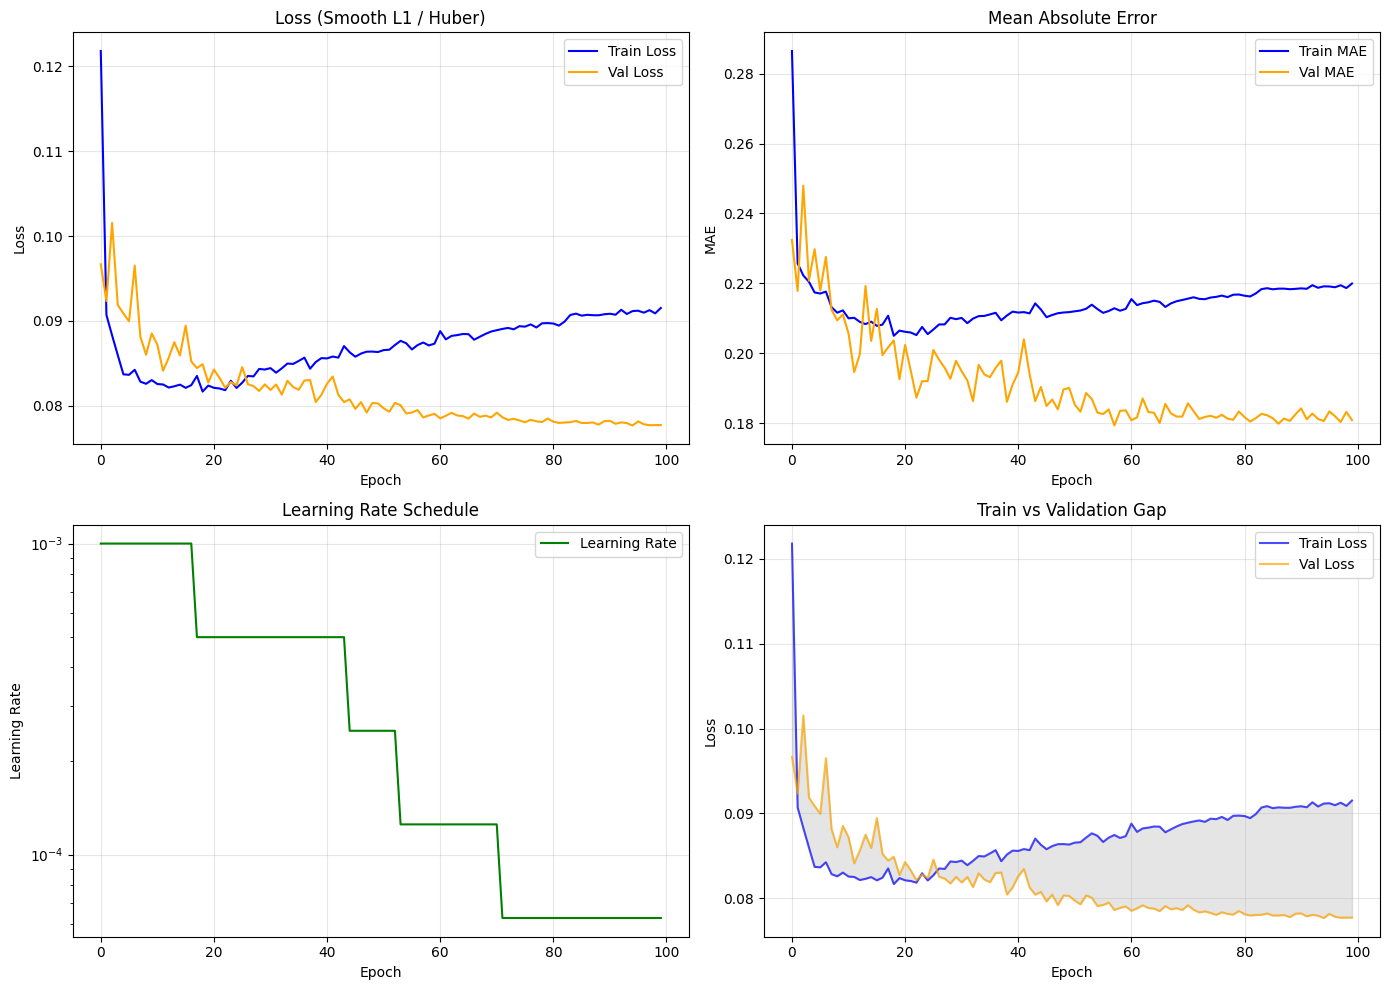


Training Summary:
  Total epochs: 100
  Best val_loss: 0.0777 (epoch 95)
  Final train_loss: 0.0915
  Final val_loss: 0.0777
  Final train_mae: 0.2200
  Final val_mae: 0.1809

Plot saved to: models/lstm_enc_dec/plots/training_history.png


In [ ]:
# Training loop
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot Loss
axes[0, 0].plot(history['train_loss'], label='Train Loss', color='blue')
axes[0, 0].plot(history['val_loss'], label='Val Loss', color='orange')
axes[0, 0].set_title('Loss (Smooth L1 / Huber)')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot MAE
axes[0, 1].plot(history['train_mae'], label='Train MAE', color='blue')
axes[0, 1].plot(history['val_mae'], label='Val MAE', color='orange')
axes[0, 1].set_title('Mean Absolute Error')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('MAE')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot Learning Rate
axes[1, 0].plot(history['lr'], label='Learning Rate', color='green')
axes[1, 0].set_title('Learning Rate Schedule')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Learning Rate')
axes[1, 0].set_yscale('log')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot Train vs Val Loss comparison
axes[1, 1].plot(history['train_loss'], label='Train Loss', color='blue', alpha=0.7)
axes[1, 1].plot(history['val_loss'], label='Val Loss', color='orange', alpha=0.7)
axes[1, 1].fill_between(range(len(history['train_loss'])), 
                         history['train_loss'], history['val_loss'], 
                         alpha=0.2, color='gray')
axes[1, 1].set_title('Train vs Validation Gap')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR_LSTM}/plots/training_history.png', dpi=150)
plt.show()

# Print summary statistics
print(f"\nTraining Summary:")
print(f"  Total epochs: {len(history['train_loss'])}")
print(f"  Best val_loss: {min(history['val_loss']):.4f} (epoch {history['val_loss'].index(min(history['val_loss']))+1})")
print(f"  Final train_loss: {history['train_loss'][-1]:.4f}")
print(f"  Final val_loss: {history['val_loss'][-1]:.4f}")
print(f"  Final train_mae: {history['train_mae'][-1]:.4f}")
print(f"  Final val_mae: {history['val_mae'][-1]:.4f}")
print(f"\nPlot saved to: {OUTPUT_DIR_LSTM}/plots/training_history.png")

## RNN Encoder-Decoder Model

In [21]:
class Seq2SeqRNN(nn.Module):
    def __init__(self, n_input_features, n_output_features, pred_horizon, 
                 encoder_hidden=128, decoder_hidden=64, n_layers=2, dropout=0.3):
        super(Seq2SeqRNN, self).__init__()
        
        self.pred_horizon = pred_horizon
        self.n_output_features = n_output_features
        self.decoder_hidden = decoder_hidden
        
        # Encoder
        self.encoder = nn.RNN(
            n_input_features, encoder_hidden, 
            num_layers=n_layers, batch_first=True, dropout=dropout
        )
        
        # Bridge
        self.bridge = nn.Linear(encoder_hidden, decoder_hidden)
        
        # Decoder
        self.decoder = nn.RNN(
            n_output_features, decoder_hidden,
            num_layers=n_layers, batch_first=True, dropout=dropout
        )
        
        # Output projection
        self.fc_out = nn.Sequential(
            nn.Linear(decoder_hidden, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, n_output_features)
        )
        
    def forward(self, x, teacher_forcing_ratio=0.0, target=None):
        batch_size = x.size(0)
        
        encoder_out, encoder_hidden = self.encoder(x)

        decoder_hidden = torch.tanh(self.bridge(encoder_hidden[-1])).unsqueeze(0)
        decoder_hidden = decoder_hidden.repeat(2, 1, 1)
        
        decoder_input = torch.zeros(batch_size, 1, self.n_output_features).to(x.device)
        
        outputs = []
        for t in range(self.pred_horizon):
            decoder_out, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
            
            output = self.fc_out(decoder_out.squeeze(1))
            outputs.append(output)
            
            if target is not None and random.random() < teacher_forcing_ratio:
                decoder_input = target[:, t:t+1, :]
            else:
                decoder_input = output.unsqueeze(1)
        
        outputs = torch.stack(outputs, dim=1)
        return outputs

model_rnn = Seq2SeqRNN(
    n_input_features=len(INPUT_FEATURES),
    n_output_features=len(TARGET_FEATURES),
    pred_horizon=PREDICTION_HORIZON,
    encoder_hidden=128,
    decoder_hidden=64,
    n_layers=2,
    dropout=0.3
).to(DEVICE)

print(model_rnn)
print(f"\nModel moved to: {DEVICE}")

# Count parameters
total_params = sum(p.numel() for p in model_rnn.parameters())
trainable_params = sum(p.numel() for p in model_rnn.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Seq2SeqRNN(
  (encoder): RNN(6, 128, num_layers=2, batch_first=True, dropout=0.3)
  (bridge): Linear(in_features=128, out_features=64, bias=True)
  (decoder): RNN(4, 64, num_layers=2, batch_first=True, dropout=0.3)
  (fc_out): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=64, out_features=4, bias=True)
  )
)

Model moved to: cuda
Total parameters: 75,908
Trainable parameters: 75,908


In [22]:
OUTPUT_DIR_RNN = "models/rnn_enc_dec"
os.makedirs(OUTPUT_DIR_RNN, exist_ok=True)
os.makedirs(f"{OUTPUT_DIR_RNN}/plots", exist_ok=True)

print(f"Output directory: {OUTPUT_DIR_RNN}")

PATIENCE = 15

criterion = nn.SmoothL1Loss()

optimizer = torch.optim.Adam(model_rnn.parameters(), lr=0.001, weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-6
)

INITIAL_TF_RATIO = 0.5
TF_DECAY = 0.98

print("\nSeq2Seq Training components configured:")
print(f"  - Loss: Smooth L1 (Huber) over {PREDICTION_HORIZON} steps")
print("  - Optimizer: Adam (lr=0.001)")
print("  - Scheduler: ReduceLROnPlateau (factor=0.5, patience=5)")
print(f"  - Teacher Forcing: {INITIAL_TF_RATIO} → decays by {TF_DECAY}/epoch")
print(f"  - Early Stopping: patience={PATIENCE}")
print(f"  - Dropout: 0.3 (encoder/decoder), 0.1 (output layer)")

Output directory: models/rnn_enc_dec

Seq2Seq Training components configured:
  - Loss: Smooth L1 (Huber) over 10 steps
  - Optimizer: Adam (lr=0.001)
  - Scheduler: ReduceLROnPlateau (factor=0.5, patience=5)
  - Teacher Forcing: 0.5 → decays by 0.98/epoch
  - Early Stopping: patience=15
  - Dropout: 0.3 (encoder/decoder), 0.1 (output layer)


In [ ]:
# Training loop
EPOCHS = 100

history = {
    'train_loss': [],
    'val_loss': [],
    'train_mae': [],
    'val_mae': [],
    'lr': [],
    'teacher_forcing': []
}

best_val_loss = float('inf')
patience_counter = 0
best_model_state = None
teacher_forcing_ratio = INITIAL_TF_RATIO

print(f"Training Seq2Seq RNN ({PREDICTION_HORIZON}-step prediction)")

for epoch in range(EPOCHS):
    model_rnn.train()
    train_loss = 0.0
    train_mae = 0.0
    
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        
        outputs = model_rnn(batch_X, teacher_forcing_ratio=teacher_forcing_ratio, target=batch_y)
        
        loss = criterion(outputs, batch_y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model_rnn.parameters(), max_norm=1.0)
        optimizer.step()
        
        train_loss += loss.item()
        train_mae += torch.mean(torch.abs(outputs - batch_y)).item()
    
    train_loss /= len(train_loader)
    train_mae /= len(train_loader)
    
    model_rnn.eval()
    val_loss = 0.0
    val_mae = 0.0
    
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            outputs = model_rnn(batch_X, teacher_forcing_ratio=0.0)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
            val_mae += torch.mean(torch.abs(outputs - batch_y)).item()
    
    val_loss /= len(val_loader)
    val_mae /= len(val_loader)

    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    
    teacher_forcing_ratio = max(0.0, teacher_forcing_ratio * TF_DECAY)
    
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_mae'].append(train_mae)
    history['val_mae'].append(val_mae)
    history['lr'].append(current_lr)
    history['teacher_forcing'].append(teacher_forcing_ratio)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_state = model_rnn.state_dict().copy()
        
        torch.save(best_model_state, f'{OUTPUT_DIR_RNN}/best_model.pth')
        print(f"Epoch {epoch+1}/{EPOCHS} - loss: {train_loss:.4f} - mae: {train_mae:.4f} - val_loss: {val_loss:.4f} - val_mae: {val_mae:.4f} - tf: {teacher_forcing_ratio:.3f} ✓")
    else:
        patience_counter += 1
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}/{EPOCHS} - loss: {train_loss:.4f} - mae: {train_mae:.4f} - val_loss: {val_loss:.4f} - val_mae: {val_mae:.4f} - tf: {teacher_forcing_ratio:.3f}")
    
    if patience_counter >= PATIENCE:
        print(f"\nEarly stopping triggered after {epoch+1} epochs")
        break

if best_model_state is not None:
    model_rnn.load_state_dict(best_model_state)
    print(f"\nRestored best model with val_loss: {best_val_loss:.4f}")

# Save final model and history
torch.save(model_rnn.state_dict(), f'{OUTPUT_DIR_RNN}/best_model.pth')
with open(f'{OUTPUT_DIR_RNN}/training_history.json', 'w') as f:
    json.dump(history, f)

print(f"\nModel saved to: {OUTPUT_DIR_RNN}/best_model.pth")

Training Seq2Seq RNN (10-step prediction)
Epoch 1/100 - loss: 0.1055 - mae: 0.2671 - val_loss: 0.0935 - val_mae: 0.2348 - tf: 0.490 ✓
Epoch 2/100 - loss: 0.0844 - mae: 0.2273 - val_loss: 0.0921 - val_mae: 0.2293 - tf: 0.480 ✓
Epoch 3/100 - loss: 0.0809 - mae: 0.2205 - val_loss: 0.0884 - val_mae: 0.2169 - tf: 0.471 ✓
Epoch 4/100 - loss: 0.0782 - mae: 0.2157 - val_loss: 0.0861 - val_mae: 0.2164 - tf: 0.461 ✓
Epoch 5/100 - loss: 0.0781 - mae: 0.2149 - val_loss: 0.0930 - val_mae: 0.2385 - tf: 0.452
Epoch 8/100 - loss: 0.0755 - mae: 0.2068 - val_loss: 0.0857 - val_mae: 0.2128 - tf: 0.425 ✓
Epoch 10/100 - loss: 0.0752 - mae: 0.2046 - val_loss: 0.0861 - val_mae: 0.2166 - tf: 0.409
Epoch 11/100 - loss: 0.0755 - mae: 0.2045 - val_loss: 0.0817 - val_mae: 0.2030 - tf: 0.400 ✓
Epoch 15/100 - loss: 0.0770 - mae: 0.2072 - val_loss: 0.0841 - val_mae: 0.2077 - tf: 0.369
Epoch 18/100 - loss: 0.0741 - mae: 0.1970 - val_loss: 0.0780 - val_mae: 0.1863 - tf: 0.348 ✓
Epoch 20/100 - loss: 0.0741 - mae: 0.197

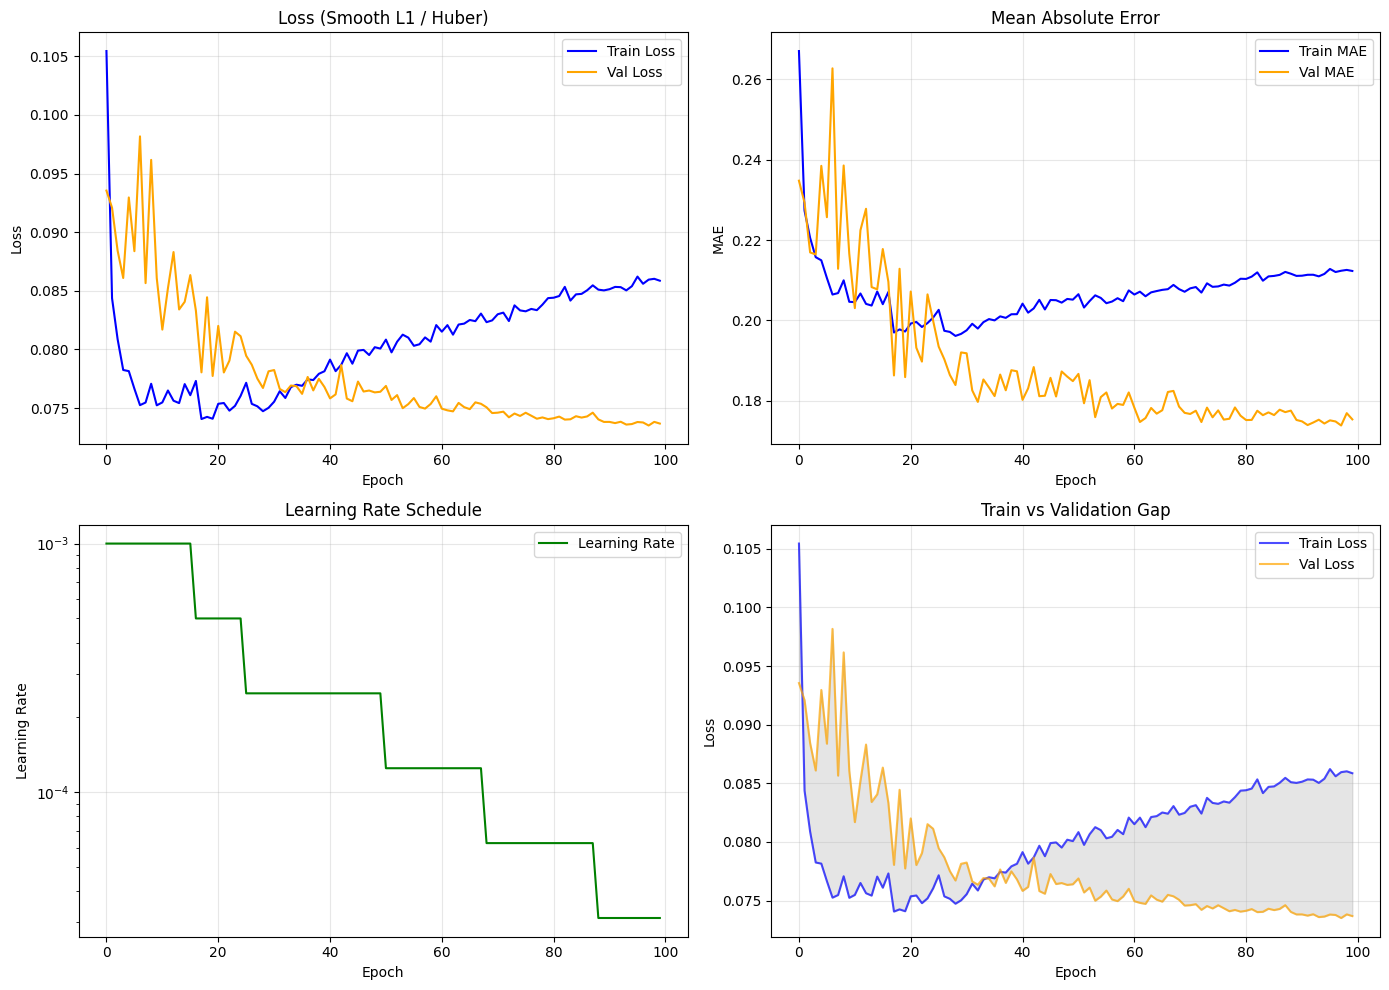


Training Summary:
  Total epochs: 100
  Best val_loss: 0.0735 (epoch 98)
  Final train_loss: 0.0859
  Final val_loss: 0.0737
  Final train_mae: 0.2123
  Final val_mae: 0.1753

Plot saved to: models/rnn_enc_dec/plots/training_history.png


In [ ]:
# Training loop
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot Loss
axes[0, 0].plot(history['train_loss'], label='Train Loss', color='blue')
axes[0, 0].plot(history['val_loss'], label='Val Loss', color='orange')
axes[0, 0].set_title('Loss (Smooth L1 / Huber)')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot MAE
axes[0, 1].plot(history['train_mae'], label='Train MAE', color='blue')
axes[0, 1].plot(history['val_mae'], label='Val MAE', color='orange')
axes[0, 1].set_title('Mean Absolute Error')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('MAE')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot Learning Rate
axes[1, 0].plot(history['lr'], label='Learning Rate', color='green')
axes[1, 0].set_title('Learning Rate Schedule')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Learning Rate')
axes[1, 0].set_yscale('log')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot Train vs Val Loss comparison
axes[1, 1].plot(history['train_loss'], label='Train Loss', color='blue', alpha=0.7)
axes[1, 1].plot(history['val_loss'], label='Val Loss', color='orange', alpha=0.7)
axes[1, 1].fill_between(range(len(history['train_loss'])), 
                         history['train_loss'], history['val_loss'], 
                         alpha=0.2, color='gray')
axes[1, 1].set_title('Train vs Validation Gap')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR_RNN}/plots/training_history.png', dpi=150)
plt.show()

# Print summary statistics
print(f"\nTraining Summary:")
print(f"  Total epochs: {len(history['train_loss'])}")
print(f"  Best val_loss: {min(history['val_loss']):.4f} (epoch {history['val_loss'].index(min(history['val_loss']))+1})")
print(f"  Final train_loss: {history['train_loss'][-1]:.4f}")
print(f"  Final val_loss: {history['val_loss'][-1]:.4f}")
print(f"  Final train_mae: {history['train_mae'][-1]:.4f}")
print(f"  Final val_mae: {history['val_mae'][-1]:.4f}")
print(f"\nPlot saved to: {OUTPUT_DIR_RNN}/plots/training_history.png")

## Transformer Model

In [23]:
import math
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

class Seq2SeqTransformer(nn.Module):
    def __init__(self, n_input_features, n_output_features, pred_horizon, 
                 d_model=128, nhead=4, n_layers=2, dropout=0.3):
        super(Seq2SeqTransformer, self).__init__()
        
        self.pred_horizon = pred_horizon
        self.n_output_features = n_output_features
        self.d_model = d_model
        
        # Encoder
        self.encoder_input_layer = nn.Linear(n_input_features, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        
        # Decoder
        self.decoder_input_layer = nn.Linear(n_output_features, d_model)
        self.pos_decoder = PositionalEncoding(d_model, dropout)
        
        decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=nhead, batch_first=True, dropout=dropout)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=n_layers)
        
        # Output projection
        self.fc_out = nn.Sequential(
            nn.Linear(d_model, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, n_output_features)
        )
        
    def forward(self, x, teacher_forcing_ratio=0.0, target=None):
        batch_size = x.size(0)
        
        src = self.encoder_input_layer(x) 
        src = self.pos_encoder(src)
        
        memory = self.transformer_encoder(src)

        decoder_input = torch.zeros(batch_size, 1, self.n_output_features).to(x.device)
        
        outputs = []
        
        # Autoregressive Decoding
        for t in range(self.pred_horizon):
            tgt = self.decoder_input_layer(decoder_input)
            tgt = self.pos_decoder(tgt)
            
            decoder_out = self.transformer_decoder(tgt, memory)
            
            last_step_out = decoder_out[:, -1, :]
            
            output = self.fc_out(last_step_out)
            outputs.append(output)
            
            # Teacher forcing
            if target is not None and random.random() < teacher_forcing_ratio:
                next_in = target[:, t:t+1, :]
            else:
                next_in = output.unsqueeze(1)

            decoder_input = torch.cat([decoder_input, next_in], dim=1)
        
        outputs = torch.stack(outputs, dim=1)
        return outputs

model_transformer = Seq2SeqTransformer(
    n_input_features=len(INPUT_FEATURES),
    n_output_features=len(TARGET_FEATURES),
    pred_horizon=PREDICTION_HORIZON,
    d_model=64,
    nhead=4,
    n_layers=2,
    dropout=0.3
).to(DEVICE)

print(model_transformer)
print(f"\nModel moved to: {DEVICE}")

# Count parameters
total_params = sum(p.numel() for p in model_transformer.parameters())
trainable_params = sum(p.numel() for p in model_transformer.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Seq2SeqTransformer(
  (encoder_input_layer): Linear(in_features=6, out_features=64, bias=True)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=2048, bias=True)
        (dropout): Dropout(p=0.3, inplace=False)
        (linear2): Linear(in_features=2048, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.3, inplace=False)
        (dropout2): Dropout(p=0.3, inplace=False)
      )
    )
  )
  (decoder_input_layer): Linear(in_features=4, out_features=64, bias=True)
  (pos_decoder): PositionalEnco

In [24]:
OUTPUT_DIR_TRANSFORMER = "models/transformer_enc_dec"
os.makedirs(OUTPUT_DIR_TRANSFORMER, exist_ok=True)
os.makedirs(f"{OUTPUT_DIR_TRANSFORMER}/plots", exist_ok=True)

print(f"Output directory: {OUTPUT_DIR_TRANSFORMER}")

PATIENCE = 15

criterion = nn.SmoothL1Loss()

optimizer = torch.optim.Adam(model_transformer.parameters(), lr=0.001, weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-6
)

INITIAL_TF_RATIO = 0.5
TF_DECAY = 0.98

print("\nSeq2Seq Training components configured:")
print(f"  - Loss: Smooth L1 (Huber) over {PREDICTION_HORIZON} steps")
print("  - Optimizer: Adam (lr=0.001)")
print("  - Scheduler: ReduceLROnPlateau (factor=0.5, patience=5)")
print(f"  - Teacher Forcing: {INITIAL_TF_RATIO} → decays by {TF_DECAY}/epoch")
print(f"  - Early Stopping: patience={PATIENCE}")
print(f"  - Dropout: 0.3 (encoder/decoder), 0.1 (output layer)")

Output directory: models/transformer_enc_dec

Seq2Seq Training components configured:
  - Loss: Smooth L1 (Huber) over 10 steps
  - Optimizer: Adam (lr=0.001)
  - Scheduler: ReduceLROnPlateau (factor=0.5, patience=5)
  - Teacher Forcing: 0.5 → decays by 0.98/epoch
  - Early Stopping: patience=15
  - Dropout: 0.3 (encoder/decoder), 0.1 (output layer)


In [ ]:
# Training loop
EPOCHS = 100

history = {
    'train_loss': [],
    'val_loss': [],
    'train_mae': [],
    'val_mae': [],
    'lr': [],
    'teacher_forcing': []
}

best_val_loss = float('inf')
patience_counter = 0
best_model_state = None
teacher_forcing_ratio = INITIAL_TF_RATIO

print(f"Training Seq2Seq Transformer ({PREDICTION_HORIZON}-step prediction)")

for epoch in range(EPOCHS):
    model_transformer.train()
    train_loss = 0.0
    train_mae = 0.0
    
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        
        outputs = model_transformer(batch_X, teacher_forcing_ratio=teacher_forcing_ratio, target=batch_y)
        
        loss = criterion(outputs, batch_y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model_transformer.parameters(), max_norm=1.0)
        optimizer.step()
        
        train_loss += loss.item()
        train_mae += torch.mean(torch.abs(outputs - batch_y)).item()
    
    train_loss /= len(train_loader)
    train_mae /= len(train_loader)
    
    # Validation (no teacher forcing)
    model_transformer.eval()
    val_loss = 0.0
    val_mae = 0.0
    
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            outputs = model_transformer(batch_X, teacher_forcing_ratio=0.0)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
            val_mae += torch.mean(torch.abs(outputs - batch_y)).item()
    
    val_loss /= len(val_loader)
    val_mae /= len(val_loader)

    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    
    # Decay teacher forcing
    teacher_forcing_ratio = max(0.0, teacher_forcing_ratio * TF_DECAY)
    
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_mae'].append(train_mae)
    history['val_mae'].append(val_mae)
    history['lr'].append(current_lr)
    history['teacher_forcing'].append(teacher_forcing_ratio)
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_state = model_transformer.state_dict().copy()
        
        torch.save(best_model_state, f'{OUTPUT_DIR_TRANSFORMER}/best_model.pth')
        print(f"Epoch {epoch+1}/{EPOCHS} - loss: {train_loss:.4f} - mae: {train_mae:.4f} - val_loss: {val_loss:.4f} - val_mae: {val_mae:.4f} - tf: {teacher_forcing_ratio:.3f} ✓")
    else:
        patience_counter += 1
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}/{EPOCHS} - loss: {train_loss:.4f} - mae: {train_mae:.4f} - val_loss: {val_loss:.4f} - val_mae: {val_mae:.4f} - tf: {teacher_forcing_ratio:.3f}")
    
    if patience_counter >= PATIENCE:
        print(f"\nEarly stopping triggered after {epoch+1} epochs")
        break

if best_model_state is not None:
    model_transformer.load_state_dict(best_model_state)
    print(f"\nRestored best model with val_loss: {best_val_loss:.4f}")

# Save final model and history
torch.save(model_transformer.state_dict(), f'{OUTPUT_DIR_TRANSFORMER}/best_model.pth')
with open(f'{OUTPUT_DIR_TRANSFORMER}/training_history.json', 'w') as f:
    json.dump(history, f)

print(f"\nModel saved to: {OUTPUT_DIR_TRANSFORMER}/best_model.pth")

Training Seq2Seq Transformer (10-step prediction)
Epoch 1/100 - loss: 0.1141 - mae: 0.2900 - val_loss: 0.1006 - val_mae: 0.2469 - tf: 0.490 ✓
Epoch 3/100 - loss: 0.0922 - mae: 0.2355 - val_loss: 0.0928 - val_mae: 0.2257 - tf: 0.471 ✓
Epoch 5/100 - loss: 0.0894 - mae: 0.2267 - val_loss: 0.0916 - val_mae: 0.2168 - tf: 0.452 ✓
Epoch 7/100 - loss: 0.0891 - mae: 0.2249 - val_loss: 0.0911 - val_mae: 0.2162 - tf: 0.434 ✓
Epoch 9/100 - loss: 0.0893 - mae: 0.2237 - val_loss: 0.0911 - val_mae: 0.2155 - tf: 0.417 ✓
Epoch 10/100 - loss: 0.0885 - mae: 0.2220 - val_loss: 0.0898 - val_mae: 0.2121 - tf: 0.409 ✓
Epoch 13/100 - loss: 0.0896 - mae: 0.2245 - val_loss: 0.0897 - val_mae: 0.2179 - tf: 0.385 ✓
Epoch 14/100 - loss: 0.0893 - mae: 0.2238 - val_loss: 0.0895 - val_mae: 0.2153 - tf: 0.377 ✓
Epoch 15/100 - loss: 0.0900 - mae: 0.2254 - val_loss: 0.0870 - val_mae: 0.2073 - tf: 0.369 ✓
Epoch 20/100 - loss: 0.0906 - mae: 0.2261 - val_loss: 0.0928 - val_mae: 0.2230 - tf: 0.334
Epoch 22/100 - loss: 0.0885

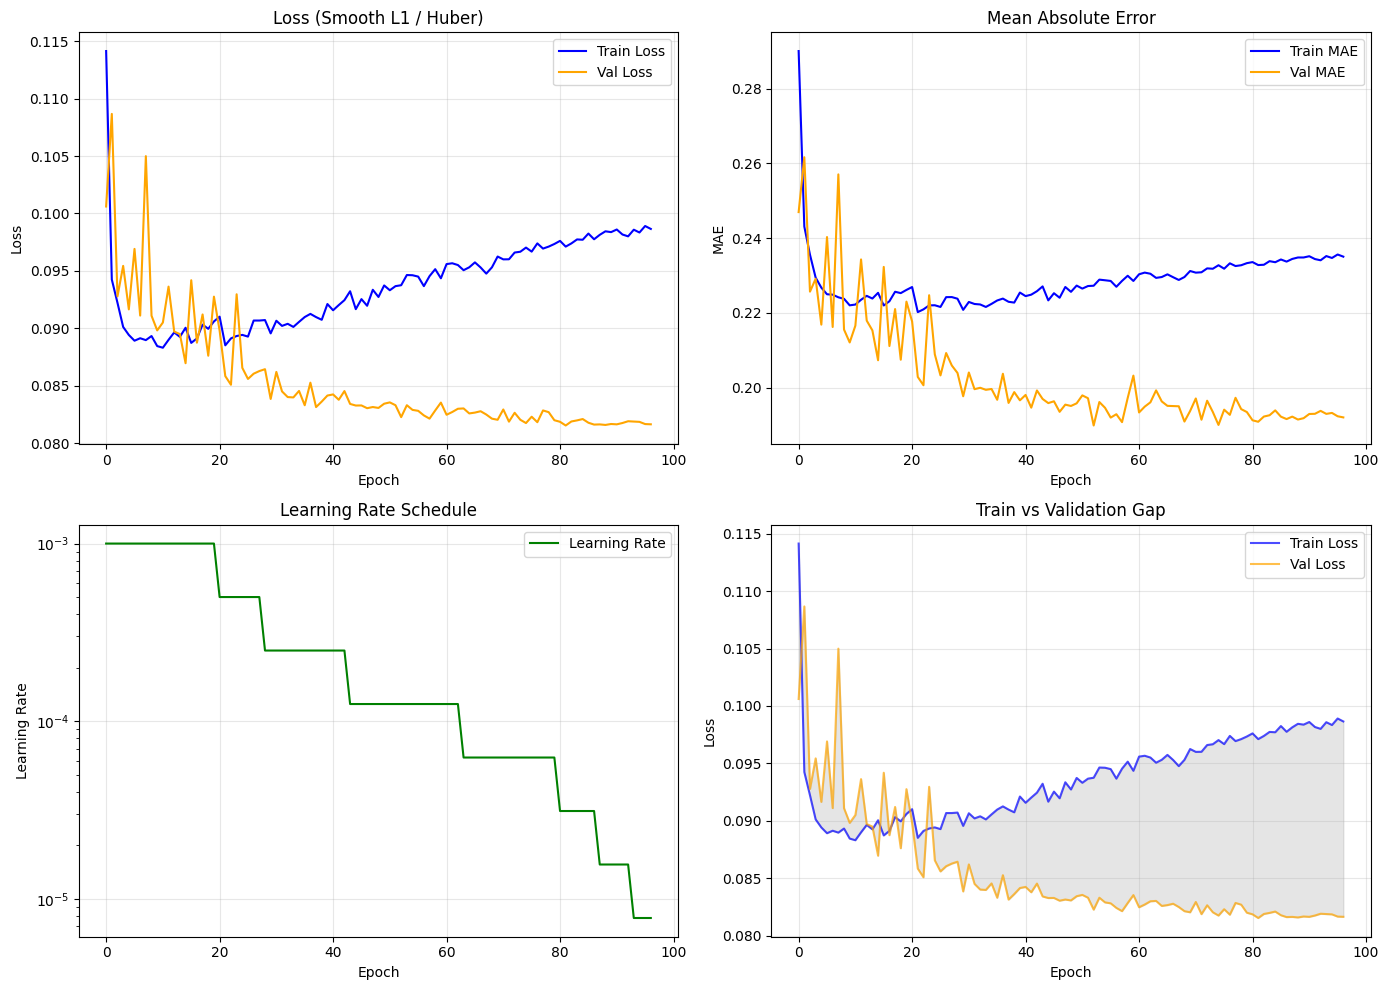


Training Summary:
  Total epochs: 97
  Best val_loss: 0.0815 (epoch 82)
  Final train_loss: 0.0987
  Final val_loss: 0.0816
  Final train_mae: 0.2350
  Final val_mae: 0.1920

Plot saved to: models/transformer_enc_dec/plots/training_history.png


In [ ]:
# Training loop
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot Loss
axes[0, 0].plot(history['train_loss'], label='Train Loss', color='blue')
axes[0, 0].plot(history['val_loss'], label='Val Loss', color='orange')
axes[0, 0].set_title('Loss (Smooth L1 / Huber)')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot MAE
axes[0, 1].plot(history['train_mae'], label='Train MAE', color='blue')
axes[0, 1].plot(history['val_mae'], label='Val MAE', color='orange')
axes[0, 1].set_title('Mean Absolute Error')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('MAE')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot Learning Rate
axes[1, 0].plot(history['lr'], label='Learning Rate', color='green')
axes[1, 0].set_title('Learning Rate Schedule')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Learning Rate')
axes[1, 0].set_yscale('log')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot Train vs Val Loss comparison
axes[1, 1].plot(history['train_loss'], label='Train Loss', color='blue', alpha=0.7)
axes[1, 1].plot(history['val_loss'], label='Val Loss', color='orange', alpha=0.7)
axes[1, 1].fill_between(range(len(history['train_loss'])), 
                         history['train_loss'], history['val_loss'], 
                         alpha=0.2, color='gray')
axes[1, 1].set_title('Train vs Validation Gap')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR_TRANSFORMER}/plots/training_history.png', dpi=150)
plt.show()

# Print summary statistics
print(f"\nTraining Summary:")
print(f"  Total epochs: {len(history['train_loss'])}")
print(f"  Best val_loss: {min(history['val_loss']):.4f} (epoch {history['val_loss'].index(min(history['val_loss']))+1})")
print(f"  Final train_loss: {history['train_loss'][-1]:.4f}")
print(f"  Final val_loss: {history['val_loss'][-1]:.4f}")
print(f"  Final train_mae: {history['train_mae'][-1]:.4f}")
print(f"  Final val_mae: {history['val_mae'][-1]:.4f}")
print(f"\nPlot saved to: {OUTPUT_DIR_TRANSFORMER}/plots/training_history.png")

# Evaluation on Test Set

### Load saved models

In [25]:
# Load GRU model
model.load_state_dict(torch.load(f'{OUTPUT_DIR}/best_model.pth'))
model.eval()

# Load LSTM model
model_lstm.load_state_dict(torch.load(f'{OUTPUT_DIR_LSTM}/best_model.pth'))
model_lstm.eval()

# Load RNN model
model_rnn.load_state_dict(torch.load(f'{OUTPUT_DIR_RNN}/best_model.pth'))
model_rnn.eval()

# Load Transformer model
model_transformer.load_state_dict(torch.load(f'{OUTPUT_DIR_TRANSFORMER}/best_model.pth'))
model_transformer.eval()

print("✓ All models loaded successfully!")

✓ All models loaded successfully!


### GRU evaluations

In [26]:
# Evaluate Seq2Seq on test set
all_preds = []
all_targets = []
test_loss = 0.0
test_mae = 0.0

print(f"Evaluating {PREDICTION_HORIZON}-step Seq2Seq predictions...")

with torch.no_grad():
    for batch_X, batch_y in tqdm(test_loader, desc="Testing"):
        outputs = model(batch_X, teacher_forcing_ratio=0.0)
        loss = criterion(outputs, batch_y)
        test_loss += loss.item()
        test_mae += torch.mean(torch.abs(outputs - batch_y)).item()
        
        all_preds.append(outputs.cpu().numpy())
        all_targets.append(batch_y.cpu().numpy())

test_loss /= len(test_loader)
test_mae /= len(test_loader)

print(f"\nTest Loss: {test_loss:.6f}")
print(f"Test MAE (normalized): {test_mae:.6f}")

# Stack and inverse transform Seq2Seq predictions
y_pred_normalized = np.concatenate(all_preds, axis=0)
y_true_normalized = np.concatenate(all_targets, axis=0)
    
n_samples, n_steps, n_feats = y_pred_normalized.shape
y_pred_raw = scaler_y.inverse_transform(y_pred_normalized.reshape(-1, n_feats)).reshape(n_samples, n_steps, n_feats)
y_true_raw = scaler_y.inverse_transform(y_true_normalized.reshape(-1, n_feats)).reshape(n_samples, n_steps, n_feats)

print(f"Inverse transformed to raw values")

# Convert Seq2Seq deltas to absolute positions for all horizon steps
last_lats = original_positions_test['last_lat'].values
last_lons = original_positions_test['last_lon'].values

pred_lat_abs_all = np.zeros((len(last_lats), PREDICTION_HORIZON))
pred_lon_abs_all = np.zeros((len(last_lats), PREDICTION_HORIZON))
true_lat_abs_all = np.zeros((len(last_lats), PREDICTION_HORIZON))
true_lon_abs_all = np.zeros((len(last_lats), PREDICTION_HORIZON))

for t in range(PREDICTION_HORIZON):
    if t == 0:
        pred_lat_abs_all[:, t] = last_lats + y_pred_raw[:, t, 0]
        pred_lon_abs_all[:, t] = last_lons + y_pred_raw[:, t, 1]
    else:
        pred_lat_abs_all[:, t] = pred_lat_abs_all[:, t-1] + y_pred_raw[:, t, 0]
        pred_lon_abs_all[:, t] = pred_lon_abs_all[:, t-1] + y_pred_raw[:, t, 1]
    
    # True positions from stored original_positions
    true_lat_abs_all[:, t] = original_positions_test[f'target_lat_{t}'].values
    true_lon_abs_all[:, t] = original_positions_test[f'target_lon_{t}'].values

Evaluating 10-step Seq2Seq predictions...


Testing: 100%|██████████| 183/183 [00:01<00:00, 91.90it/s] 


Test Loss: 0.106952
Test MAE (normalized): 0.207609
Inverse transformed to raw values


In [27]:
# Calculate distance errors per horizon step
print(f"\n{'Step':<8} {'Time':>8} {'Mean Dist':>12} {'Median':>10} {'90th %':>10}")
print("="*55)

distance_errors_per_step = []
for t in range(PREDICTION_HORIZON):
    dist_errors = haversine_m(
        pred_lat_abs_all[:, t], pred_lon_abs_all[:, t],
        true_lat_abs_all[:, t], true_lon_abs_all[:, t]
    )
    distance_errors_per_step.append(dist_errors)
    
    time_min = (t + 1) * INTERVAL
    print(f"Step {t+1:<3} {time_min:>5} min {np.mean(dist_errors):>10.1f} m {np.median(dist_errors):>8.1f} m {np.percentile(dist_errors, 90):>8.1f} m")

# Calculate per-feature metrics on first step
pred_delta_lat = y_pred_raw[:, 0, 0]
pred_delta_lon = y_pred_raw[:, 0, 1]
pred_sog = y_pred_raw[:, 0, 2]
pred_delta_cog = y_pred_raw[:, 0, 3]

true_delta_lat = y_true_raw[:, 0, 0]
true_delta_lon = y_true_raw[:, 0, 1]
true_sog = y_true_raw[:, 0, 2]
true_delta_cog = y_true_raw[:, 0, 3]

print(f"\n{'Feature':<15} {'MAE':>12} {'RMSE':>12}")
print("-" * 40)

# delta_Lat
dlat_mae = np.mean(np.abs(pred_delta_lat - true_delta_lat))
dlat_rmse = np.sqrt(np.mean((pred_delta_lat - true_delta_lat)**2))
print(f"{'delta_Lat':<15} {dlat_mae:>12.6f} {dlat_rmse:>12.6f}")

# delta_Lon
dlon_mae = np.mean(np.abs(pred_delta_lon - true_delta_lon))
dlon_rmse = np.sqrt(np.mean((pred_delta_lon - true_delta_lon)**2))
print(f"{'delta_Lon':<15} {dlon_mae:>12.6f} {dlon_rmse:>12.6f}")

# SOG
sog_mae = np.mean(np.abs(pred_sog - true_sog))
sog_rmse = np.sqrt(np.mean((pred_sog - true_sog)**2))
print(f"{'SOG':<15} {sog_mae:>12.6f} {sog_rmse:>12.6f}")

# delta_COG
dcog_mae = np.mean(np.abs(pred_delta_cog - true_delta_cog))
dcog_rmse = np.sqrt(np.mean((pred_delta_cog - true_delta_cog)**2))
print(f"{'delta_COG':<15} {dcog_mae:>12.4f}° {dcog_rmse:>12.4f}°")


Step         Time    Mean Dist     Median     90th %
Step 1       5 min       92.5 m     42.5 m    213.4 m
Step 2      10 min      160.7 m     73.2 m    369.7 m
Step 3      15 min      238.8 m    106.1 m    563.7 m
Step 4      20 min      350.8 m    147.7 m    875.2 m
Step 5      25 min      490.8 m    195.5 m   1290.0 m
Step 6      30 min      654.5 m    247.9 m   1764.0 m
Step 7      35 min      841.9 m    305.5 m   2350.5 m
Step 8      40 min     1047.5 m    368.3 m   3041.7 m
Step 9      45 min     1269.0 m    436.7 m   3773.1 m
Step 10     50 min     1505.1 m    505.9 m   4544.5 m

Feature                  MAE         RMSE
----------------------------------------
delta_Lat           0.000535     0.001291
delta_Lon           0.000953     0.002173
SOG                 0.156358     0.313032
delta_COG             6.2729°      15.1946°


### LSTM evaluations

In [28]:
# Evaluate Seq2Seq on test set
all_preds = []
all_targets = []
test_loss = 0.0
test_mae = 0.0

print(f"Evaluating {PREDICTION_HORIZON}-step Seq2Seq predictions...")

with torch.no_grad():
    for batch_X, batch_y in tqdm(test_loader, desc="Testing"):
        outputs = model_lstm(batch_X, teacher_forcing_ratio=0.0)
        loss = criterion(outputs, batch_y)
        test_loss += loss.item()
        test_mae += torch.mean(torch.abs(outputs - batch_y)).item()
        
        all_preds.append(outputs.cpu().numpy())
        all_targets.append(batch_y.cpu().numpy())

test_loss /= len(test_loader)
test_mae /= len(test_loader)

print(f"\nTest Loss: {test_loss:.6f}")
print(f"Test MAE (normalized): {test_mae:.6f}")

# Stack and inverse transform Seq2Seq predictions
y_pred_normalized = np.concatenate(all_preds, axis=0)
y_true_normalized = np.concatenate(all_targets, axis=0)
    
n_samples, n_steps, n_feats = y_pred_normalized.shape
y_pred_raw = scaler_y.inverse_transform(y_pred_normalized.reshape(-1, n_feats)).reshape(n_samples, n_steps, n_feats)
y_true_raw = scaler_y.inverse_transform(y_true_normalized.reshape(-1, n_feats)).reshape(n_samples, n_steps, n_feats)

print(f"Inverse transformed to raw values")

# Convert Seq2Seq deltas to absolute positions for all horizon steps
last_lats = original_positions_test['last_lat'].values
last_lons = original_positions_test['last_lon'].values

pred_lat_abs_all = np.zeros((len(last_lats), PREDICTION_HORIZON))
pred_lon_abs_all = np.zeros((len(last_lats), PREDICTION_HORIZON))
true_lat_abs_all = np.zeros((len(last_lats), PREDICTION_HORIZON))
true_lon_abs_all = np.zeros((len(last_lats), PREDICTION_HORIZON))

for t in range(PREDICTION_HORIZON):
    if t == 0:
        pred_lat_abs_all[:, t] = last_lats + y_pred_raw[:, t, 0]
        pred_lon_abs_all[:, t] = last_lons + y_pred_raw[:, t, 1]
    else:
        pred_lat_abs_all[:, t] = pred_lat_abs_all[:, t-1] + y_pred_raw[:, t, 0]
        pred_lon_abs_all[:, t] = pred_lon_abs_all[:, t-1] + y_pred_raw[:, t, 1]
    
    # True positions from stored original_positions
    true_lat_abs_all[:, t] = original_positions_test[f'target_lat_{t}'].values
    true_lon_abs_all[:, t] = original_positions_test[f'target_lon_{t}'].values

Evaluating 10-step Seq2Seq predictions...


Testing: 100%|██████████| 183/183 [00:01<00:00, 96.04it/s]


Test Loss: 0.106990
Test MAE (normalized): 0.207734
Inverse transformed to raw values


In [29]:
# Calculate distance errors per horizon step
print(f"\n{'Step':<8} {'Time':>8} {'Mean Dist':>12} {'Median':>10} {'90th %':>10}")
print("="*55)

distance_errors_per_step = []
for t in range(PREDICTION_HORIZON):
    dist_errors = haversine_m(
        pred_lat_abs_all[:, t], pred_lon_abs_all[:, t],
        true_lat_abs_all[:, t], true_lon_abs_all[:, t]
    )
    distance_errors_per_step.append(dist_errors)
    
    time_min = (t + 1) * INTERVAL
    print(f"Step {t+1:<3} {time_min:>5} min {np.mean(dist_errors):>10.1f} m {np.median(dist_errors):>8.1f} m {np.percentile(dist_errors, 90):>8.1f} m")

# Calculate per-feature metrics on first step
pred_delta_lat = y_pred_raw[:, 0, 0]
pred_delta_lon = y_pred_raw[:, 0, 1]
pred_sog = y_pred_raw[:, 0, 2]
pred_delta_cog = y_pred_raw[:, 0, 3]

true_delta_lat = y_true_raw[:, 0, 0]
true_delta_lon = y_true_raw[:, 0, 1]
true_sog = y_true_raw[:, 0, 2]
true_delta_cog = y_true_raw[:, 0, 3]

print(f"\n{'Feature':<15} {'MAE':>12} {'RMSE':>12}")
print("-" * 40)

# delta_Lat
dlat_mae = np.mean(np.abs(pred_delta_lat - true_delta_lat))
dlat_rmse = np.sqrt(np.mean((pred_delta_lat - true_delta_lat)**2))
print(f"{'delta_Lat':<15} {dlat_mae:>12.6f} {dlat_rmse:>12.6f}")

# delta_Lon
dlon_mae = np.mean(np.abs(pred_delta_lon - true_delta_lon))
dlon_rmse = np.sqrt(np.mean((pred_delta_lon - true_delta_lon)**2))
print(f"{'delta_Lon':<15} {dlon_mae:>12.6f} {dlon_rmse:>12.6f}")

# SOG
sog_mae = np.mean(np.abs(pred_sog - true_sog))
sog_rmse = np.sqrt(np.mean((pred_sog - true_sog)**2))
print(f"{'SOG':<15} {sog_mae:>12.6f} {sog_rmse:>12.6f}")

# delta_COG
dcog_mae = np.mean(np.abs(pred_delta_cog - true_delta_cog))
dcog_rmse = np.sqrt(np.mean((pred_delta_cog - true_delta_cog)**2))
print(f"{'delta_COG':<15} {dcog_mae:>12.4f}° {dcog_rmse:>12.4f}°")


Step         Time    Mean Dist     Median     90th %
Step 1       5 min       98.1 m     43.1 m    229.8 m
Step 2      10 min      178.3 m     78.6 m    420.9 m
Step 3      15 min      264.0 m    111.9 m    629.2 m
Step 4      20 min      379.2 m    156.2 m    942.2 m
Step 5      25 min      520.6 m    206.0 m   1334.6 m
Step 6      30 min      684.9 m    265.3 m   1794.7 m
Step 7      35 min      872.5 m    341.6 m   2343.4 m
Step 8      40 min     1078.9 m    428.1 m   2987.9 m
Step 9      45 min     1302.1 m    527.8 m   3668.8 m
Step 10     50 min     1539.8 m    639.0 m   4405.7 m

Feature                  MAE         RMSE
----------------------------------------
delta_Lat           0.000588     0.001361
delta_Lon           0.000973     0.002277
SOG                 0.130454     0.312394
delta_COG             6.3281°      15.2581°


### RNN evaluations

In [30]:
# Evaluate Seq2Seq on test set
all_preds = []
all_targets = []
test_loss = 0.0
test_mae = 0.0

print(f"Evaluating {PREDICTION_HORIZON}-step Seq2Seq predictions...")

with torch.no_grad():
    for batch_X, batch_y in tqdm(test_loader, desc="Testing"):
        outputs = model_rnn(batch_X, teacher_forcing_ratio=0.0)
        loss = criterion(outputs, batch_y)
        test_loss += loss.item()
        test_mae += torch.mean(torch.abs(outputs - batch_y)).item()
        
        all_preds.append(outputs.cpu().numpy())
        all_targets.append(batch_y.cpu().numpy())

test_loss /= len(test_loader)
test_mae /= len(test_loader)

print(f"\nTest Loss: {test_loss:.6f}")
print(f"Test MAE (normalized): {test_mae:.6f}")

# Stack and inverse transform Seq2Seq predictions
y_pred_normalized = np.concatenate(all_preds, axis=0)
y_true_normalized = np.concatenate(all_targets, axis=0)
    
n_samples, n_steps, n_feats = y_pred_normalized.shape
y_pred_raw = scaler_y.inverse_transform(y_pred_normalized.reshape(-1, n_feats)).reshape(n_samples, n_steps, n_feats)
y_true_raw = scaler_y.inverse_transform(y_true_normalized.reshape(-1, n_feats)).reshape(n_samples, n_steps, n_feats)

print(f"Inverse transformed to raw values")

# Convert Seq2Seq deltas to absolute positions for all horizon steps
last_lats = original_positions_test['last_lat'].values
last_lons = original_positions_test['last_lon'].values

pred_lat_abs_all = np.zeros((len(last_lats), PREDICTION_HORIZON))
pred_lon_abs_all = np.zeros((len(last_lats), PREDICTION_HORIZON))
true_lat_abs_all = np.zeros((len(last_lats), PREDICTION_HORIZON))
true_lon_abs_all = np.zeros((len(last_lats), PREDICTION_HORIZON))

for t in range(PREDICTION_HORIZON):
    if t == 0:
        pred_lat_abs_all[:, t] = last_lats + y_pred_raw[:, t, 0]
        pred_lon_abs_all[:, t] = last_lons + y_pred_raw[:, t, 1]
    else:
        pred_lat_abs_all[:, t] = pred_lat_abs_all[:, t-1] + y_pred_raw[:, t, 0]
        pred_lon_abs_all[:, t] = pred_lon_abs_all[:, t-1] + y_pred_raw[:, t, 1]
    
    # True positions from stored original_positions
    true_lat_abs_all[:, t] = original_positions_test[f'target_lat_{t}'].values
    true_lon_abs_all[:, t] = original_positions_test[f'target_lon_{t}'].values

Evaluating 10-step Seq2Seq predictions...


Testing: 100%|██████████| 183/183 [00:01<00:00, 112.73it/s]


Test Loss: 0.101494
Test MAE (normalized): 0.201984
Inverse transformed to raw values


In [31]:
# Calculate distance errors per horizon step
print(f"\n{'Step':<8} {'Time':>8} {'Mean Dist':>12} {'Median':>10} {'90th %':>10}")
print("="*55)

distance_errors_per_step = []
for t in range(PREDICTION_HORIZON):
    dist_errors = haversine_m(
        pred_lat_abs_all[:, t], pred_lon_abs_all[:, t],
        true_lat_abs_all[:, t], true_lon_abs_all[:, t]
    )
    distance_errors_per_step.append(dist_errors)
    
    time_min = (t + 1) * INTERVAL
    print(f"Step {t+1:<3} {time_min:>5} min {np.mean(dist_errors):>10.1f} m {np.median(dist_errors):>8.1f} m {np.percentile(dist_errors, 90):>8.1f} m")

# Calculate per-feature metrics on first step
pred_delta_lat = y_pred_raw[:, 0, 0]
pred_delta_lon = y_pred_raw[:, 0, 1]
pred_sog = y_pred_raw[:, 0, 2]
pred_delta_cog = y_pred_raw[:, 0, 3]

true_delta_lat = y_true_raw[:, 0, 0]
true_delta_lon = y_true_raw[:, 0, 1]
true_sog = y_true_raw[:, 0, 2]
true_delta_cog = y_true_raw[:, 0, 3]

print(f"\n{'Feature':<15} {'MAE':>12} {'RMSE':>12}")
print("-" * 40)

# delta_Lat
dlat_mae = np.mean(np.abs(pred_delta_lat - true_delta_lat))
dlat_rmse = np.sqrt(np.mean((pred_delta_lat - true_delta_lat)**2))
print(f"{'delta_Lat':<15} {dlat_mae:>12.6f} {dlat_rmse:>12.6f}")

# delta_Lon
dlon_mae = np.mean(np.abs(pred_delta_lon - true_delta_lon))
dlon_rmse = np.sqrt(np.mean((pred_delta_lon - true_delta_lon)**2))
print(f"{'delta_Lon':<15} {dlon_mae:>12.6f} {dlon_rmse:>12.6f}")

# SOG
sog_mae = np.mean(np.abs(pred_sog - true_sog))
sog_rmse = np.sqrt(np.mean((pred_sog - true_sog)**2))
print(f"{'SOG':<15} {sog_mae:>12.6f} {sog_rmse:>12.6f}")

# delta_COG
dcog_mae = np.mean(np.abs(pred_delta_cog - true_delta_cog))
dcog_rmse = np.sqrt(np.mean((pred_delta_cog - true_delta_cog)**2))
print(f"{'delta_COG':<15} {dcog_mae:>12.4f}° {dcog_rmse:>12.4f}°")


Step         Time    Mean Dist     Median     90th %
Step 1       5 min       90.5 m     41.4 m    206.6 m
Step 2      10 min      166.4 m     77.4 m    377.2 m
Step 3      15 min      251.6 m    115.7 m    579.1 m
Step 4      20 min      369.8 m    166.2 m    902.1 m
Step 5      25 min      516.7 m    224.0 m   1285.8 m
Step 6      30 min      685.7 m    290.1 m   1755.7 m
Step 7      35 min      878.7 m    369.6 m   2276.1 m
Step 8      40 min     1091.3 m    453.5 m   2933.3 m
Step 9      45 min     1320.5 m    550.0 m   3657.8 m
Step 10     50 min     1564.0 m    655.4 m   4415.4 m

Feature                  MAE         RMSE
----------------------------------------
delta_Lat           0.000506     0.001228
delta_Lon           0.000952     0.002125
SOG                 0.146915     0.321990
delta_COG             5.1396°      12.4335°


### Transformer evaluations

In [32]:
# Evaluate Seq2Seq on test set
all_preds = []
all_targets = []
test_loss = 0.0
test_mae = 0.0

print(f"Evaluating {PREDICTION_HORIZON}-step Seq2Seq predictions...")

with torch.no_grad():
    for batch_X, batch_y in tqdm(test_loader, desc="Testing"):
        outputs = model_transformer(batch_X)
        loss = criterion(outputs, batch_y)
        test_loss += loss.item()
        test_mae += torch.mean(torch.abs(outputs - batch_y)).item()
        
        all_preds.append(outputs.cpu().numpy())
        all_targets.append(batch_y.cpu().numpy())

test_loss /= len(test_loader)
test_mae /= len(test_loader)

print(f"\nTest Loss: {test_loss:.6f}")
print(f"Test MAE (normalized): {test_mae:.6f}")

# Stack and inverse transform Seq2Seq predictions
y_pred_normalized = np.concatenate(all_preds, axis=0)
y_true_normalized = np.concatenate(all_targets, axis=0)
    
n_samples, n_steps, n_feats = y_pred_normalized.shape
y_pred_raw = scaler_y.inverse_transform(y_pred_normalized.reshape(-1, n_feats)).reshape(n_samples, n_steps, n_feats)
y_true_raw = scaler_y.inverse_transform(y_true_normalized.reshape(-1, n_feats)).reshape(n_samples, n_steps, n_feats)

print(f"Inverse transformed to raw values")

# Convert Seq2Seq deltas to absolute positions for all horizon steps
last_lats = original_positions_test['last_lat'].values
last_lons = original_positions_test['last_lon'].values

pred_lat_abs_all = np.zeros((len(last_lats), PREDICTION_HORIZON))
pred_lon_abs_all = np.zeros((len(last_lats), PREDICTION_HORIZON))
true_lat_abs_all = np.zeros((len(last_lats), PREDICTION_HORIZON))
true_lon_abs_all = np.zeros((len(last_lats), PREDICTION_HORIZON))

for t in range(PREDICTION_HORIZON):
    if t == 0:
        pred_lat_abs_all[:, t] = last_lats + y_pred_raw[:, t, 0]
        pred_lon_abs_all[:, t] = last_lons + y_pred_raw[:, t, 1]
    else:
        pred_lat_abs_all[:, t] = pred_lat_abs_all[:, t-1] + y_pred_raw[:, t, 0]
        pred_lon_abs_all[:, t] = pred_lon_abs_all[:, t-1] + y_pred_raw[:, t, 1]
    
    # True positions from stored original_positions
    true_lat_abs_all[:, t] = original_positions_test[f'target_lat_{t}'].values
    true_lon_abs_all[:, t] = original_positions_test[f'target_lon_{t}'].values

Evaluating 10-step Seq2Seq predictions...


Testing: 100%|██████████| 183/183 [00:08<00:00, 20.49it/s]


Test Loss: 0.110846
Test MAE (normalized): 0.216106
Inverse transformed to raw values


In [33]:
# Calculate distance errors per horizon step
print(f"\n{'Step':<8} {'Time':>8} {'Mean Dist':>12} {'Median':>10} {'90th %':>10}")
print("="*55)

distance_errors_per_step = []
for t in range(PREDICTION_HORIZON):
    dist_errors = haversine_m(
        pred_lat_abs_all[:, t], pred_lon_abs_all[:, t],
        true_lat_abs_all[:, t], true_lon_abs_all[:, t]
    )
    distance_errors_per_step.append(dist_errors)
    
    time_min = (t + 1) * INTERVAL
    print(f"Step {t+1:<3} {time_min:>5} min {np.mean(dist_errors):>10.1f} m {np.median(dist_errors):>8.1f} m {np.percentile(dist_errors, 90):>8.1f} m")

# Calculate per-feature metrics on first step
pred_delta_lat = y_pred_raw[:, 0, 0]
pred_delta_lon = y_pred_raw[:, 0, 1]
pred_sog = y_pred_raw[:, 0, 2]
pred_delta_cog = y_pred_raw[:, 0, 3]

true_delta_lat = y_true_raw[:, 0, 0]
true_delta_lon = y_true_raw[:, 0, 1]
true_sog = y_true_raw[:, 0, 2]
true_delta_cog = y_true_raw[:, 0, 3]

print(f"\n{'Feature':<15} {'MAE':>12} {'RMSE':>12}")
print("-" * 40)

# delta_Lat
dlat_mae = np.mean(np.abs(pred_delta_lat - true_delta_lat))
dlat_rmse = np.sqrt(np.mean((pred_delta_lat - true_delta_lat)**2))
print(f"{'delta_Lat':<15} {dlat_mae:>12.6f} {dlat_rmse:>12.6f}")

# delta_Lon
dlon_mae = np.mean(np.abs(pred_delta_lon - true_delta_lon))
dlon_rmse = np.sqrt(np.mean((pred_delta_lon - true_delta_lon)**2))
print(f"{'delta_Lon':<15} {dlon_mae:>12.6f} {dlon_rmse:>12.6f}")

# SOG
sog_mae = np.mean(np.abs(pred_sog - true_sog))
sog_rmse = np.sqrt(np.mean((pred_sog - true_sog)**2))
print(f"{'SOG':<15} {sog_mae:>12.6f} {sog_rmse:>12.6f}")

# delta_COG
dcog_mae = np.mean(np.abs(pred_delta_cog - true_delta_cog))
dcog_rmse = np.sqrt(np.mean((pred_delta_cog - true_delta_cog)**2))
print(f"{'delta_COG':<15} {dcog_mae:>12.4f}° {dcog_rmse:>12.4f}°")


Step         Time    Mean Dist     Median     90th %
Step 1       5 min      117.6 m     65.5 m    253.6 m
Step 2      10 min      208.2 m    116.4 m    453.9 m
Step 3      15 min      307.0 m    155.1 m    712.2 m
Step 4      20 min      432.6 m    200.3 m   1078.5 m
Step 5      25 min      584.7 m    240.5 m   1539.5 m
Step 6      30 min      762.0 m    289.5 m   2046.0 m
Step 7      35 min      964.5 m    354.6 m   2665.0 m
Step 8      40 min     1186.9 m    437.3 m   3358.1 m
Step 9      45 min     1426.3 m    525.4 m   4075.3 m
Step 10     50 min     1681.6 m    623.3 m   4849.2 m

Feature                  MAE         RMSE
----------------------------------------
delta_Lat           0.000657     0.001336
delta_Lon           0.001232     0.002355
SOG                 0.256459     0.399213
delta_COG             6.6823°      15.6860°


# Visualization

In [34]:
model_configs = [
    {
        'name': 'GRU',
        'model_path': 'models/gru_enc_dec/best_model.pth',
        'model_instance': model,
        'color': 'red'
    },
    {
        'name': 'LSTM',
        'model_path': 'models/lstm_enc_dec/best_model.pth',
        'model_instance': model_lstm,
        'color': 'green'
    },
    {
        'name': 'RNN',
        'model_path': 'models/rnn_enc_dec/best_model.pth',
        'model_instance': model_rnn,
        'color': 'orange'
    },
    {
        'name': 'Transformer',
        'model_path': 'models/transformer_enc_dec/best_model.pth',
        'model_instance': model_transformer,
        'color': 'purple'
    }
]

## Multi-Horizon Model Comparison

In [82]:
# Multi-horizon comparison

# Play around with MAX_STEPS
MAX_STEPS = 30

multihorizon_map = compare_multiple_models_multihorizon(
    model_configs=model_configs,
    X_test=X_test,
    test_indices=test_indices,
    segment_info=segment_info,
    mmsi_test_set=mmsi_test_set,
    df_delta=df_delta,
    original_positions_test=original_positions_test,
    scaler_y=scaler_y,
    scaler_lat_lon=scaler_lat_lon,
    target_features=TARGET_FEATURES,
    input_features=INPUT_FEATURES,
    prediction_horizon=PREDICTION_HORIZON,
    sequence_length=SEQUENCE_LENGTH,
    interval=INTERVAL,
    device=DEVICE,
    max_steps=MAX_STEPS,
    random_mmsi=None,
    save_path=f'models/multi_model_multihorizon_{MAX_STEPS * INTERVAL}min.html'
)

Multi-Horizon Model Comparison (150 minutes)
Selected MMSI: 246724000, Segment: 2
Segment length: 82 points (410 min)
Observed: 20 points (100 min)
Ground truth: 30 points (150 min)

Processing GRU...
  GRU - Mean Error:  11174.1 m
             - Median Error:   7535.8 m
             - Max Error:  34367.8 m

Processing LSTM...
  LSTM - Mean Error:  11199.8 m
             - Median Error:   7641.6 m
             - Max Error:  32254.6 m

Processing RNN...
  RNN - Mean Error:  19942.9 m
             - Median Error:  17168.7 m
             - Max Error:  49134.9 m

Processing Transformer...
  Transformer - Mean Error:  13716.2 m
             - Median Error:  11219.7 m
             - Max Error:  34526.4 m

Map saved to: models/multi_model_multihorizon_150min.html

Multi-horizon comparison complete! 4 models visualized.
